# Modeling the NBA Draft

We've used salary information with data from professional players already and found some results, but often what is most important for teams is to attempt to find players who will be good through the draft instead of finding good players once they're already in the NBA.  Thus, teams focus a lot of time and energy on attempting to evaluate college players to figure out who is going to be the next big star in the league.  Instead of watching games and relying on scouts to help us out, we're going to try to model the draft using data.

In [2]:
#Import statements
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

Our first task is to match up the individual player info we already have with their draft position, in terms of visualizing how good NBA teams are at drafting talent.

In [3]:
from bs4 import BeautifulSoup

import requests

We start by grabbing the HTML text of the wikipedia pages containing the results of all the NBA drafts since 1989 (the first year where there were only 2 rounds of the draft).

In [4]:
#Begin by instantiating two lists, one which will contain the years, the other containing the text of the wiki page
years = []
htmltext = []

#Now use a for loop, iterating over all years we care about
for i in range(1989, 2016):
    
    #We begin by adding the year to the years list
    years.append(i)
    
    #Now we get the htmltext for that specific year, using string interpolation to pick out a specific year
    t=requests.get("http://en.wikipedia.org/wiki/%(number)i_NBA_draft" % {"number" : i})
    
    #Now, we add this text to our htmltext list
    htmltext.append(t.text)
    
    #Finally, we wait a second between runs of the for loop
    time.sleep(1)
    
#Now that the lists years and htmltext are properly defined, we simply use the zip
#and dict functions to create the dictionary we want
yearsdict = dict(zip(years, htmltext))

Having done this, we write a function to convert the htmltext of such a wiki page into a list, where the pick numbers, players, teams that chose them, and colleges they played for are reported.

In [5]:
#Given a year and the previously made dictionary, output a list containing all the draft information
#from that year's NBA Draft
def draftyear(year, dictofyears):
    
    #Create a list where we'll store dictionary info
    dictlist = []
    
    #First make a BeautifulSoup object to help parse the data
    soup = BeautifulSoup(dictofyears[year], "html.parser")
    
    #Now, we find the tables corresponding to the draft data.  Some of the pages have both the rounds of the draft
    #included in the same table, and some have a table for each round, so we need to take all the tables and fix later
    pagetables = soup.find_all("table", attrs={"class":"wikitable"})
    
    #Now, if the table has a "Pick" column, we keep it, and if not we throw it out
    #We also throw out tables referring to lottery picks, which also have a "Pick" column
    drafttables = []
    for table in pagetables:
        if len(table.find_all(string = "Pick")) != 0 and len(table.find_all(string = "Lottery")) == 0:
            drafttables.append(table)
    
    #Now, we take two cases separately - either there are two tables containing the draft information, or just one
    #Some of the draft wiki pages are formatted differently
    if len(drafttables) == 1:
        
        #If there's only one table, we find all the rows from that table
        draftrows = drafttables[0].find_all("tr")[1:]
        
        #Iterate over the rows to get information
        for row in draftrows:
            
            #Find all the entries in the table by searching for the td tags
            rowtds = row.find_all("td")
            
            #If there is only one table, then the table looks as follows:
            #Round | Pick | Player | Position | Nationality | Team who picked them | College/previous team
            #We leverage this setup for our dictionary to get the round and draft pick
            draftround = int(rowtds[0].get_text())
            
            #The Minnesota Timberwolves forfeited a pick in 2004, leading to a column entry which is just a
            #dash instead of a pick number - we deal with that separately
            if rowtds[1].get_text() == '-':
                draftpick = None
            else:
                draftpick = int(rowtds[1].get_text())
            
            #Now, we find the player's name
            #In 2001, the Minnesota Timberwolves forfeited the 29th pick in the draft due to a salary cap violation,
            #so if there is no name here, we ignore this pick
            if rowtds[2].find("a") == None:
                name = None
                NBAteam = None
                oldteam = None
            else:
                name = rowtds[2].find("a").get_text()
                
                #We also need to deal with some unicode characters so that the player names match the ones
                #from the player database
                name = name.replace(u'\u0111', u'dj').replace(u'\u010d', u'c').replace(u'\u0161', u's')
                name = name.replace(u'\u017d', u'Z').replace(u'\u0219', u's').replace(u'\u0107', u'c')
                name = name.replace(u'\u0160', u'S').replace(u'\xfc', u'u').replace(u'\u011f', u'g')
                name = name.replace(u'\u017e', u'z').replace(u'\xc1', u'A').replace(u'\xe1', u'a')
                name = name.replace(u'\xf1', u'n').replace(u'\xf3', u'o').replace(u'\xe9', u'e')
                name = name.replace(u'\u0159', u'r').replace(u'\xed', u'i').replace(u'\u010c', u'C')
                name = name.replace(u'\u0130', u'I').replace(u'\u015f', u's').replace(u'\u0131', u'i')
                name = name.replace(u'\xef', u'i').replace(u'\xf6', u'o').replace(u'\xe4', u'a')
                name = name.replace(u'\xfa', u'u').replace(u'\xea', u'e').replace(u'\xeb', u'e')
                name = name.replace(u'\xdc', u'U').replace(u'\u0146', u'n').replace(u'\u016b', u'u')
                name = name.replace(u'\u0101', u'a').replace(u'\u0123', u'g').replace(u'\xe3', u'a')
                name = name.replace(u'\xe7', u'c').replace(u'\xd6', u'O').replace(u'\xdf', u'ss')
                name = name.replace(u'\xfd', u'y')
                
                #Now convert to a regular string, since we've removed the unicode characters
                name = str(name)
            
                #Finally, find the NBA team and college team (or other professional organization) they came from
                #Some teams are not hyperlinked as expected on some pages, so in that case we just get
                #the text
                if rowtds[5].find("a") == None:
                    NBAteam = rowtds[5].get_text()
                    NBAteam = str(NBAteam)
                else:
                    NBAteam = rowtds[5].find("a").get_text()
                    NBAteam = str(NBAteam)
                
                #There are a few edge cases involving teams that are improperly linked - we deal with them here
                if NBAteam == '[9]':
                    NBAteam = 'Boston Celtics'
                elif NBAteam == '[15]':
                    NBAteam = 'New York Knicks'
                elif NBAteam == '[18]':
                    NBAteam = 'Seattle SuperSonics'
                elif name == 'Dahntay Jones':
                    NBAteam = 'Boston Celtics'
                
                #Some of the old teams, especially if they are not colleges, have strange unicode characters in them
                #as well, which we need to remove.
                if rowtds[6].find("a") == None:
                    oldteam = rowtds[6].get_text()
                    oldteam = oldteam.replace(u'\u017d', u'Z').replace(u'\xfc', u'u').replace(u'\u0107', u'c')
                    oldteam = oldteam.replace(u'\u0160', u'S').replace(u'\xe1', u'a').replace(u'\u0131', u'i')
                    oldteam = oldteam.replace(u'\u015f', u's').replace(u'\xdc', u'U').replace(u'\xf6', u'o')
                    oldteam = oldteam.replace(u'\xe3', u'a').replace(u'\xe0', u'a').replace(u'\xe8', u'e')
                    oldteam = oldteam.replace(u'\xe7', u'c').replace(u'\xed', u'i').replace(u'\xf3', u'o')
                    oldteam = oldteam.replace(u'\xc9', u'E')
                    oldteam = str(oldteam)
                else:
                    oldteam = rowtds[6].find("a").get_text()
                    
                    #Removing unicode characters once again
                    oldteam = oldteam.replace(u'\u2013', u'-').replace(u'\u017d', u'Z').replace(u'\xfc', u'u')
                    oldteam = oldteam.replace(u'\u0107', u'c').replace(u'\u0160', u'S').replace(u'\xe1', u'a')
                    oldteam = oldteam.replace(u'\u0131', u'i').replace(u'\u015f', u's').replace(u'\xdc', u'U')
                    oldteam = oldteam.replace(u'\xf6', u'o').replace(u'\xe3', u'a').replace(u'\xe0', u'a')
                    oldteam = oldteam.replace(u'\xe8', u'e').replace(u'\xe7', u'c').replace(u'\xed', u'i')
                    oldteam = oldteam.replace(u'\xf3', u'o').replace(u'\xc9', u'E')
                    oldteam = str(oldteam)
            
            #Now we make a dictionary of this information and append it to our dictlist
            dictlist.append(dict(Round = draftround, Pick = draftpick, Player = name, 
                                 NBA_Team = NBAteam, Old_Team = oldteam))
    
    else:
        
        #If there are two tables, we have to do each one separately - the first one corresponds to the first round,
        #and the second one corresponds to the second round
        
        #We keep track of which round we are on with a counter
        draftround = 1
        
        #Now deal with each round separately
        for table in drafttables:
            
            #Start by finding all the rows in the table again
            draftroundrows = table.find_all("tr")[1:]
            
            #Iterate over the rows
            for row in draftroundrows:
                
                #Find the entries in the rows
                rowtds = row.find_all("td")
                
                #If there are two tables, the tables look as follows (note that there is no longer a Round column)
                #Pick | Player | Nationality | NBA Team | College/Other Team
                draftpick = int(rowtds[0].get_text())
                name = rowtds[1].find("a").get_text()
                
                #We again have to fix some unicode characters.  Thankfully, we don't have to deal with forfeited picks
                name = name.replace(u'\u0111', u'dj').replace(u'\u010d', u'c').replace(u'\u0161', u's')
                name = name.replace(u'\u017d', u'Z').replace(u'\u0219', u's').replace(u'\u0107', u'c')
                name = name.replace(u'\u0160', u'S').replace(u'\xfc', u'u').replace(u'\u011f', u'g')
                name = name.replace(u'\u017e', u'z').replace(u'\xc1', u'A').replace(u'\xe1', u'a')
                name = name.replace(u'\xf1', u'n').replace(u'\xf3', u'o').replace(u'\xe9', u'e')
                name = name.replace(u'\u0159', u'r').replace(u'\xed', u'i').replace(u'\u010c', u'C')
                name = name.replace(u'\u0130', u'I').replace(u'\u015f', u's').replace(u'\u0131', u'i')
                name = name.replace(u'\xef', u'i').replace(u'\xf6', u'o').replace(u'\xe4', u'a')
                name = name.replace(u'\xfa', u'u').replace(u'\xea', u'e').replace(u'\xeb', u'e')
                name = name.replace(u'\xdc', u'U').replace(u'\u0146', u'n').replace(u'\u016b', u'u')
                name = name.replace(u'\u0101', u'a').replace(u'\u0123', u'g').replace(u'\xdf', u'ss')
                name = name.replace(u'\xfd', u'y')
                
                name = str(name)
                
                #In all such tables, the NBA teams are linked correctly so we don't need another if statement here
                NBAteam = rowtds[3].find("a").get_text()
                NBAteam = str(NBAteam)
                
                #Dealing with another edge case
                if name == 'Duane Causwell':
                    NBAteam = 'Sacramento Kings'
                
                #We do need to remove some unicode characters from the old teams again
                oldteam = rowtds[4].find("a").get_text()
                oldteam = oldteam.replace(u'\u2013', u'-').replace(u'\u017d', u'Z').replace(u'\xfc', u'u')
                oldteam = oldteam.replace(u'\u0107', u'c').replace(u'\u0160', u'S').replace(u'\xe1', u'a')
                oldteam = oldteam.replace(u'\u0131', u'i').replace(u'\u015f', u's').replace(u'\xdc', u'U')
                oldteam = oldteam.replace(u'\xf6', u'o').replace(u'\xe3', u'a').replace(u'\xe0', u'a')
                oldteam = oldteam.replace(u'\xe8', u'e').replace(u'\xe7', u'c').replace(u'\xed', u'i')
                oldteam = oldteam.replace(u'\xf3', u'o').replace(u'\xc9', u'E')
                
                oldteam = str(oldteam)
                
                #Finally, append a dictionary
                dictlist.append(dict(Round = draftround, Pick = draftpick, Player = name, 
                                     NBA_Team = NBAteam, Old_Team = oldteam))
                
            #Increment the counter to recognize the round has changed
            draftround += 1

    return dictlist

Now that we have this function, we create a dictionary which includes all this draft information and the year in which each player was drafted.

In [6]:
finaldraftlist = []

for year in range(1989, 2016):
    for player in draftyear(year, yearsdict):
        player["Year Drafted"] = year
        finaldraftlist.append(player)

Then we create a dataframe out of this dictionary.

In [7]:
draftdf = pd.DataFrame(finaldraftlist)

In [8]:
draftdf.head()

,NBA_Team,Old_Team,Pick,Player,Round,Year Drafted
0,Sacramento Kings,Louisville,1,Pervis Ellison,1,1989
1,Los Angeles Clippers,Duke,2,Danny Ferry,1,1989
2,San Antonio Spurs,Arizona,3,Sean Elliott,1,1989
3,Miami Heat,Michigan,4,Glen Rice,1,1989
4,Charlotte Hornets,North Carolina,5,J. R. Reid,1,1989


Finally, we need to convert the team names as reported on the Wiki pages, in the form "Boston Celtics", into their abbreviations "BOS" to match our other data.  Here's the values we need to match in the dataframe:

In [9]:
draftdf['NBA_Team'].unique()

array(['Sacramento Kings', 'Los Angeles Clippers', 'San Antonio Spurs',
       'Miami Heat', 'Charlotte Hornets', 'Chicago Bulls',
       'Indiana Pacers', 'Dallas Mavericks', 'Washington Bullets',
       'Minnesota Timberwolves', 'Orlando Magic', 'New Jersey Nets',
       'Boston Celtics', 'Golden State Warriors', 'Denver Nuggets',
       'Seattle SuperSonics', 'Philadelphia 76ers', 'Utah Jazz',
       'Portland Trail Blazers', 'Atlanta Hawks', 'Phoenix Suns',
       'Cleveland Cavaliers', 'Los Angeles Lakers', 'Detroit Pistons',
       'Milwaukee Bucks', 'New York Knicks', 'Houston Rockets',
       'Vancouver Grizzlies', 'Toronto Raptors', 'Portland Trailblazers',
       'Washington Wizards', None, 'Memphis Grizzlies',
       'New Orleans Hornets', 'Charlotte Bobcats',
       'New Orleans/Oklahoma City Hornets', 'Oklahoma City Thunder',
       'Brooklyn Nets', 'New Orleans Pelicans'], dtype=object)

In [10]:
teamsdict = {'Sacramento Kings' : 'SAC', 'Los Angeles Clippers' : 'LAC', 'San Antonio Spurs' : 'SAS', 
             'Miami Heat' : 'MIA', 'Charlotte Hornets' : 'CHA', 'Chicago Bulls' : 'CHI', 
             'Indiana Pacers' : 'IND', 'Dallas Mavericks' : 'DAL', 'Washington Bullets' : 'WSB', 
             'Minnesota Timberwolves' : 'MIN', 'Orlando Magic' : 'ORL', 'New Jersey Nets' : 'NJN', 
             'Boston Celtics' : 'BOS', 'Golden State Warriors' : 'GSW', 'Denver Nuggets' : 'DEN',
             'Seattle SuperSonics' : 'SEA', 'Philadelphia 76ers' : 'PHI', 'Utah Jazz' : 'UTA',
             'Portland Trail Blazers' : 'POR', 'Atlanta Hawks' : 'ATL', 'Phoenix Suns' : 'PHX',
             'Cleveland Cavaliers' : 'CLE', 'Los Angeles Lakers' : 'LAL', 'Detroit Pistons' : 'DET',
             'Milwaukee Bucks' : 'MIL', 'New York Knicks' : 'NYK', 'Houston Rockets' : 'HOU',
             'Vancouver Grizzlies' : 'VAN', 'Toronto Raptors' : 'TOR', 'Portland Trailblazers' : 'POR',
             'Washington Wizards' : 'WAS', None : 'None', 'Memphis Grizzlies' : 'MEM',
             'New Orleans Hornets' : 'NOH', 'Charlotte Bobcats' : 'CHA', 'New Orleans/Oklahoma City Hornets' : 'NOK',
             'Oklahoma City Thunder' : 'OKC', 'Brooklyn Nets' : 'BKN', 'New Orleans Pelicans' : 'NOP'}

In [11]:
draftdf['NBA_Team'] = draftdf['NBA_Team'].apply(lambda x : teamsdict[x])

Last but not least, we remove the rows corresponding to forfeited picks.

In [12]:
draftdf = draftdf[draftdf['NBA_Team'] != 'None']

In [13]:
draftdf.head(30)

,NBA_Team,Old_Team,Pick,Player,Round,Year Drafted
0,SAC,Louisville,1,Pervis Ellison,1,1989
1,LAC,Duke,2,Danny Ferry,1,1989
2,SAS,Arizona,3,Sean Elliott,1,1989
3,MIA,Michigan,4,Glen Rice,1,1989
4,CHA,North Carolina,5,J. R. Reid,1,1989
5,CHI,Oklahoma,6,Stacey King,1,1989
6,IND,Florida State,7,George McCloud,1,1989
7,DAL,Louisiana Tech,8,Randy White,1,1989
8,WSB,Georgia Tech,9,Tom Hammonds,1,1989
9,MIN,UCLA,10,Pooh Richardson,1,1989


In [14]:
draftdf.shape

(1562, 6)

There's one more issue we need to deal with in order to properly merge this dataframe of drafted players with our dataframe of NBA player data.  Some players have their names as simply a pair of initials, like "C. J. Miles" or "B. J. Bruton".  On the Basketball-Reference website, the formatting for these names is consistent, in that the names are always reported without a space between the initials: "C.J. Miles, "B.J. Bruton".  However, as we can see, Wikipedia is not always as consistent:

In [15]:
def isperiod(s):
    return s[1:2] == '.'
mask = []
for name in draftdf['Player'].values:
    mask.append(isperiod(name))
draftdf[mask]

,NBA_Team,Old_Team,Pick,Player,Round,Year Drafted
4,CHA,North Carolina,5,J. R. Reid,1,1989
17,CHI,Iowa,18,B. J. Armstrong,1,1989
90,WSB,Virginia Union,37,A.J. English,2,1990
190,NJN,Louisiana Tech,29,P. J. Brown,2,1992
289,PHI,Texas,20,B.J. Tyler,1,1994
491,VAN,Indian Hills CC,52,C.J. Bruton,2,1997
552,VAN,UCLA,56,J.R. Henderson,2,1998
593,CLE,Arizona,39,A. J. Bramlett,2,1999
600,NYK,Iowa,46,J. R. Koch,2,1999
644,CHI,Indiana,32,A.J. Guyton,2,2000


Some players have the space and some do not.  Thus, we write a quick function to eliminate the spaces from names that have them.  We simply look for the second character to be a '.' and the third to be a space, and if we find it, we eliminate that space.

In [16]:
def fixspace(s):
    if s[1:3] == '. ':
        s = s.replace(' ', '', 1)
    return s
draftdf['Player'] = draftdf['Player'].apply(fixspace)

In [17]:
draftdf[mask]

,NBA_Team,Old_Team,Pick,Player,Round,Year Drafted
4,CHA,North Carolina,5,J.R. Reid,1,1989
17,CHI,Iowa,18,B.J. Armstrong,1,1989
90,WSB,Virginia Union,37,A.J. English,2,1990
190,NJN,Louisiana Tech,29,P.J. Brown,2,1992
289,PHI,Texas,20,B.J. Tyler,1,1994
491,VAN,Indian Hills CC,52,C.J. Bruton,2,1997
552,VAN,UCLA,56,J.R. Henderson,2,1998
593,CLE,Arizona,39,A.J. Bramlett,2,1999
600,NYK,Iowa,46,J.R. Koch,2,1999
644,CHI,Indiana,32,A.J. Guyton,2,2000


Now that we have this cleaned dataframe, we save it to a CSV.

In [18]:
draftdf.to_csv("Data/NBADraft.csv", index=False)

Before we actually merge the dataframes, let's take a moment to examine the data.  Specifically, which colleges/teams produce the most NBA talent?

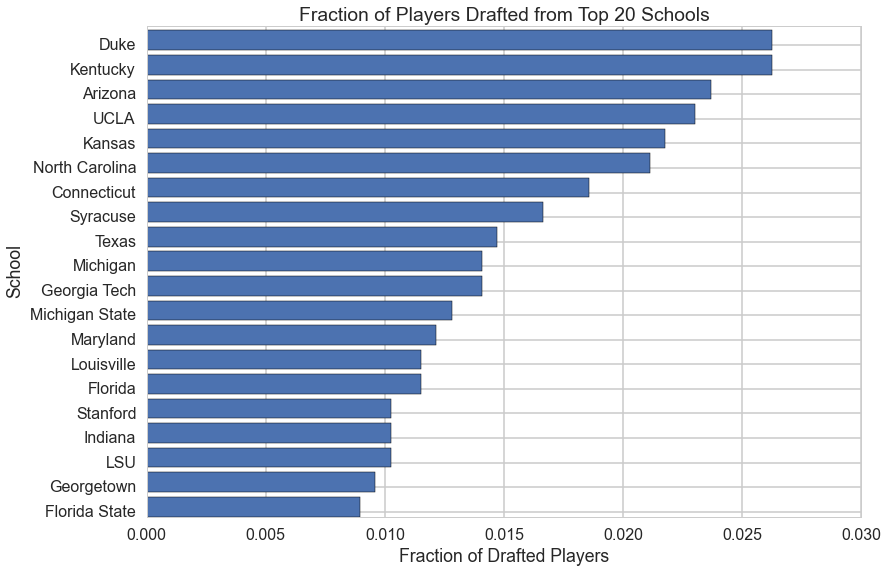

In [125]:
from operator import itemgetter

#Instantiate a list and some helpful variables
oldteamsfractions = []
numteams = 20
total = float(len(draftdf))

#For each team in our dataframe, keep track of the team name and the percentage of drafted players
#who attended to that school
for team in draftdf['Old_Team'].unique():
    oldteamsfractions.append((team, float(len(draftdf[draftdf['Old_Team'] == team]))/total))

#Now, sort the new list by the fraction and only keep the first numteams schools
oldteamsfractions = sorted(oldteamsfractions, key = itemgetter(1), reverse = True)
oldteamsfractionsfirst = oldteamsfractions[0:numteams]

#Turn our list of tuples into a list of two lists, one containing schools and the other containing fractions
teamsandfractions = zip(*oldteamsfractionsfirst)

#Now plot a bar chart of the results, with the top schools first
width = 0.2
ind = np.arange(start = numteams-1, stop = -1, step = -1)
fig, ax = plt.subplots();
rect = ax.barh(ind, teamsandfractions[1]);
ax.set_yticks(ind+width);
ax.set_yticklabels(teamsandfractions[0]);
ax.set_title('Fraction of Players Drafted from Top 20 Schools');
ax.set_ylabel('School');
ax.set_xlabel('Fraction of Drafted Players');

We see results that we expect: Duke and Kentucky have enjoyed periods of sustained dominance in college basketball, so they are right at the top, and every other school on this list has at least some reputation for success, so it makes sense that they appear here.  It is also important to note that there are no foreign teams on this list - players being drafted from foreign teams (like, for example, Dirk Nowitzki, who was drafted in 1998 from DJK Wurzburg, a German basketball team) are usually found as singletons, and teams are unlikely to keep drafting from the same foreign teams at a frequency as high as they do from colleges.

In [20]:
draftdf[draftdf['Old_Team'] == 'DJK Wurzburg']

,NBA_Team,Old_Team,Pick,Player,Round,Year Drafted
505,MIL,DJK Wurzburg,9,Dirk Nowitzki,1,1998


Now, time to match up our draft dataframe with our other data!  We first load in a dataframe consisting of all NBA data from players who have retired.  (The setup of tha Basketball-Reference site made this division much more reasonable, since the active players were listed differently).

In [21]:
retireddf = pd.read_csv('Data/dftouse.csv')
retireddf.head()

,Player,2P,2P%,2PA,3P,3P%,3PA,AST,Age,BLK,DRB,FG,FG%,FGA,FT,FT%,FTA,G,GS,Lg,MP,ORB,PF,PTS,Player.1,Pos,STL,Season,TOV,TRB,Tm,eFG%,Salary
0,Alaa Abdelnaby,55,.474,116,0,NaN,0,12.0,22,12,62,55,.474,116,25,.568,44,43,0,NBA,290,27,39,135,Alaa Abdelnaby,PF,4.0,1990-91,22,89.0,POR,.474,395000
1,Alaa Abdelnaby,178,.493,361,0,NaN,0,30.0,23,16,179,178,.493,361,76,.752,101,71,1,NBA,934,81,132,432,Alaa Abdelnaby,PF,25.0,1991-92,66,260.0,POR,.493,494000
2,Alaa Abdelnaby,245,.519,472,0,.000,1,27.0,24,26,211,245,.518,473,88,.759,116,75,52,NBA,1311,126,189,578,Alaa Abdelnaby,PF,25.0,1992-93,97,337.0,TOT,.518,500000
3,Alaa Abdelnaby,26,.473,55,0,.000,1,10.0,24,4,25,26,.464,56,12,.750,16,12,0,NBA,159,12,24,64,Alaa Abdelnaby,PF,6.0,1992-93,13,37.0,MIL,.464,500000
4,Alaa Abdelnaby,219,.525,417,0,NaN,0,17.0,24,22,186,219,.525,417,76,.760,100,63,52,NBA,1152,114,165,514,Alaa Abdelnaby,PF,19.0,1992-93,84,300.0,BOS,.525,500000


In [22]:
retireddf.shape

(8608, 33)

Now we read in the dataframe for players who are currently playing in the NBA.

In [23]:
currentdf = pd.read_csv('Data/curdf.csv')
currentdf.head()

,Player,Player.1,2P,2P%,2PA,3P,3P%,3PA,AST,Age,BLK,DRB,FG,FG%,FGA,FT,FT%,FTA,G,GS,Lg,MP,ORB,PF,PTS,Player.1_x,Pos,STL,Season,TOV,TRB,Tm,eFG%,Player.1_y,Salary
0,Quincy Acy,Quincy Acy,41,0.562,73,1,.500,2,11,22,15,47,42,0.560,75,31,0.816,38,29,0,NBA,342,30,53,116,Quincy Acy,PF,13,2012-13,17,77,TOR,0.567,Quincy Acy,665000
1,Quincy Acy,Quincy Acy,62,0.492,126,4,.267,15,28,23,26,144,66,0.468,141,35,0.660,53,63,0,NBA,847,72,122,171,Quincy Acy,SF,23,2013-14,30,216,TOT,0.482,Quincy Acy,788872
2,Quincy Acy,Quincy Acy,4,0.444,9,2,.400,5,4,23,3,10,6,0.429,14,5,0.625,8,7,0,NBA,61,5,8,19,Quincy Acy,SF,4,2013-14,2,15,TOR,0.500,Quincy Acy,788872
3,Quincy Acy,Quincy Acy,58,0.496,117,2,.200,10,24,23,23,134,60,0.472,127,30,0.667,45,56,0,NBA,786,67,114,152,Quincy Acy,SF,19,2013-14,28,201,SAC,0.480,Quincy Acy,788872
4,Quincy Acy,Quincy Acy,134,0.494,271,18,.300,60,68,24,22,222,152,0.459,331,76,0.784,97,68,22,NBA,1287,79,147,398,Quincy Acy,PF,27,2014-15,60,301,NYK,0.486,Quincy Acy,915243


In [24]:
currentdf.shape

(3728, 35)

We combine these into one dataframe to reflect all of our NBA data.

In [25]:
fulldf = pd.concat([retireddf, currentdf])
fulldf.head()

,2P,2P%,2PA,3P,3P%,3PA,AST,Age,BLK,DRB,FG,FG%,FGA,FT,FT%,FTA,G,GS,Lg,MP,ORB,PF,PTS,Player,Player.1,Player.1_x,Player.1_y,Pos,STL,Salary,Season,TOV,TRB,Tm,eFG%
0,55,.474,116,0,NaN,0,12.0,22,12,62,55,.474,116,25,.568,44,43,0,NBA,290,27,39,135,Alaa Abdelnaby,Alaa Abdelnaby,NaN,NaN,PF,4.0,395000,1990-91,22,89.0,POR,.474
1,178,.493,361,0,NaN,0,30.0,23,16,179,178,.493,361,76,.752,101,71,1,NBA,934,81,132,432,Alaa Abdelnaby,Alaa Abdelnaby,NaN,NaN,PF,25.0,494000,1991-92,66,260.0,POR,.493
2,245,.519,472,0,.000,1,27.0,24,26,211,245,.518,473,88,.759,116,75,52,NBA,1311,126,189,578,Alaa Abdelnaby,Alaa Abdelnaby,NaN,NaN,PF,25.0,500000,1992-93,97,337.0,TOT,.518
3,26,.473,55,0,.000,1,10.0,24,4,25,26,.464,56,12,.750,16,12,0,NBA,159,12,24,64,Alaa Abdelnaby,Alaa Abdelnaby,NaN,NaN,PF,6.0,500000,1992-93,13,37.0,MIL,.464
4,219,.525,417,0,NaN,0,17.0,24,22,186,219,.525,417,76,.760,100,63,52,NBA,1152,114,165,514,Alaa Abdelnaby,Alaa Abdelnaby,NaN,NaN,PF,19.0,500000,1992-93,84,300.0,BOS,.525


In [26]:
fulldf.shape

(12336, 35)

Time to merge these two dataframes!

In [27]:
mergeddf = pd.merge(draftdf, fulldf, how = 'left', on='Player')
mergeddf.head()
mergeddf.shape

(8797, 40)

In [28]:
mergeddf[mergeddf['Year Drafted'] > 2010]

,NBA_Team,Old_Team,Pick,Player,Round,Year Drafted,2P,2P%,2PA,3P,3P%,3PA,AST,Age,BLK,DRB,FG,FG%,FGA,FT,FT%,FTA,G,GS,Lg,MP,ORB,PF,PTS,Player.1,Player.1_x,Player.1_y,Pos,STL,Salary,Season,TOV,TRB,Tm,eFG%
8156,CLE,Duke,1,Kyrie Irving,1,2011,277,0.491,564,73,.399,183,275,19,20,147,350,0.469,747,171,0.872,196,51,51,NBA,1558,44,110,944,Kyrie Irving,Kyrie Irving,Kyrie Irving,PG,54,5144280,2011-12,160,191,CLE,0.517
8157,CLE,Duke,1,Kyrie Irving,1,2011,375,0.474,791,109,.391,279,350,20,21,182,484,0.452,1070,248,0.855,290,59,59,NBA,2048,34,146,1325,Kyrie Irving,Kyrie Irving,Kyrie Irving,PG,89,5530080,2012-13,191,216,CLE,0.503
8158,CLE,Duke,1,Kyrie Irving,1,2011,409,0.458,893,123,.358,344,433,21,23,207,532,0.43,1237,291,0.861,338,71,71,NBA,2496,52,163,1478,Kyrie Irving,Kyrie Irving,Kyrie Irving,PG,108,5607240,2013-14,190,259,CLE,0.48
8159,CLE,Duke,1,Kyrie Irving,1,2011,421,0.491,857,157,.415,378,389,22,20,182,578,0.468,1235,315,0.863,365,75,75,NBA,2730,55,146,1628,Kyrie Irving,Kyrie Irving,Kyrie Irving,PG,114,7070730,2014-15,186,237,CLE,0.532
8160,MIN,Arizona,2,Derrick Williams,1,2011,168,0.467,360,37,.268,138,38,20,31,234,205,0.412,498,136,0.697,195,66,15,NBA,1418,77,95,583,Derrick Williams,Derrick Williams,Derrick Williams,PF,30,4602720,2011-12,77,311,MIN,0.449
8161,MIN,Arizona,2,Derrick Williams,1,2011,273,0.463,590,65,.332,196,46,21,37,334,338,0.43,786,192,0.706,272,78,56,NBA,1916,96,127,933,Derrick Williams,Derrick Williams,Derrick Williams,PF,44,4947840,2012-13,101,430,MIN,0.471
8162,MIN,Arizona,2,Derrick Williams,1,2011,180,0.47,383,26,.263,99,56,22,20,252,206,0.427,482,186,0.718,259,78,15,NBA,1820,71,114,624,Derrick Williams,Derrick Williams,Derrick Williams,SF-PF,48,5016960,2013-14,76,323,TOT,0.454
8163,MIN,Arizona,2,Derrick Williams,1,2011,17,0.436,39,2,.133,15,1,22,4,23,19,0.352,54,14,0.875,16,11,0,NBA,162,3,9,54,Derrick Williams,Derrick Williams,Derrick Williams,PF,4,5016960,2013-14,6,26,MIN,0.37
8164,MIN,Arizona,2,Derrick Williams,1,2011,163,0.474,344,24,.286,84,55,22,16,229,187,0.437,428,172,0.708,243,67,15,NBA,1658,68,105,570,Derrick Williams,Derrick Williams,Derrick Williams,SF,44,5016960,2013-14,70,297,SAC,0.465
8165,MIN,Arizona,2,Derrick Williams,1,2011,168,0.511,329,49,.314,156,50,23,4,161,217,0.447,485,134,0.684,196,74,6,NBA,1462,41,67,617,Derrick Williams,Derrick Williams,Derrick Williams,PF,34,6331404,2014-15,56,202,SAC,0.498


We throw out the data from players who never played in the NBA or were just drafted and are still in the development league, meaning they don't have NBA stats yet.  We use 2P, the column representing the number of 2-point shots made, simply because it is the first merged value and will be a NaN value if there is no data in the fulldf.  We check for NaN by seeing if a value is equal to itself - NaN values are not equal to themselves.

In [29]:
newmask = []
mergeddf['2P'].values
for val in mergeddf['2P'].values:
    newmask.append(not (val != val))
mergeddf = mergeddf[newmask]
mergeddf.shape

(8427, 40)

In [30]:
mergeddf[mergeddf['Year Drafted'] > 2010]

,NBA_Team,Old_Team,Pick,Player,Round,Year Drafted,2P,2P%,2PA,3P,3P%,3PA,AST,Age,BLK,DRB,FG,FG%,FGA,FT,FT%,FTA,G,GS,Lg,MP,ORB,PF,PTS,Player.1,Player.1_x,Player.1_y,Pos,STL,Salary,Season,TOV,TRB,Tm,eFG%
8156,CLE,Duke,1,Kyrie Irving,1,2011,277,0.491,564,73,.399,183,275,19,20,147,350,0.469,747,171,0.872,196,51,51,NBA,1558,44,110,944,Kyrie Irving,Kyrie Irving,Kyrie Irving,PG,54,5144280,2011-12,160,191,CLE,0.517
8157,CLE,Duke,1,Kyrie Irving,1,2011,375,0.474,791,109,.391,279,350,20,21,182,484,0.452,1070,248,0.855,290,59,59,NBA,2048,34,146,1325,Kyrie Irving,Kyrie Irving,Kyrie Irving,PG,89,5530080,2012-13,191,216,CLE,0.503
8158,CLE,Duke,1,Kyrie Irving,1,2011,409,0.458,893,123,.358,344,433,21,23,207,532,0.43,1237,291,0.861,338,71,71,NBA,2496,52,163,1478,Kyrie Irving,Kyrie Irving,Kyrie Irving,PG,108,5607240,2013-14,190,259,CLE,0.48
8159,CLE,Duke,1,Kyrie Irving,1,2011,421,0.491,857,157,.415,378,389,22,20,182,578,0.468,1235,315,0.863,365,75,75,NBA,2730,55,146,1628,Kyrie Irving,Kyrie Irving,Kyrie Irving,PG,114,7070730,2014-15,186,237,CLE,0.532
8160,MIN,Arizona,2,Derrick Williams,1,2011,168,0.467,360,37,.268,138,38,20,31,234,205,0.412,498,136,0.697,195,66,15,NBA,1418,77,95,583,Derrick Williams,Derrick Williams,Derrick Williams,PF,30,4602720,2011-12,77,311,MIN,0.449
8161,MIN,Arizona,2,Derrick Williams,1,2011,273,0.463,590,65,.332,196,46,21,37,334,338,0.43,786,192,0.706,272,78,56,NBA,1916,96,127,933,Derrick Williams,Derrick Williams,Derrick Williams,PF,44,4947840,2012-13,101,430,MIN,0.471
8162,MIN,Arizona,2,Derrick Williams,1,2011,180,0.47,383,26,.263,99,56,22,20,252,206,0.427,482,186,0.718,259,78,15,NBA,1820,71,114,624,Derrick Williams,Derrick Williams,Derrick Williams,SF-PF,48,5016960,2013-14,76,323,TOT,0.454
8163,MIN,Arizona,2,Derrick Williams,1,2011,17,0.436,39,2,.133,15,1,22,4,23,19,0.352,54,14,0.875,16,11,0,NBA,162,3,9,54,Derrick Williams,Derrick Williams,Derrick Williams,PF,4,5016960,2013-14,6,26,MIN,0.37
8164,MIN,Arizona,2,Derrick Williams,1,2011,163,0.474,344,24,.286,84,55,22,16,229,187,0.437,428,172,0.708,243,67,15,NBA,1658,68,105,570,Derrick Williams,Derrick Williams,Derrick Williams,SF,44,5016960,2013-14,70,297,SAC,0.465
8165,MIN,Arizona,2,Derrick Williams,1,2011,168,0.511,329,49,.314,156,50,23,4,161,217,0.447,485,134,0.684,196,74,6,NBA,1462,41,67,617,Derrick Williams,Derrick Williams,Derrick Williams,PF,34,6331404,2014-15,56,202,SAC,0.498


Now, let's explore the data.  First, let's look player by player and plot the maximum salary that each player achieves against their pick number in the draft.  Our analysis from the salary data assumes that salary achieved should reflect the value of a player, so this should effectively represent the maximum value that each player achieved during his playing career.

In [31]:
players = mergeddf.groupby('Player')

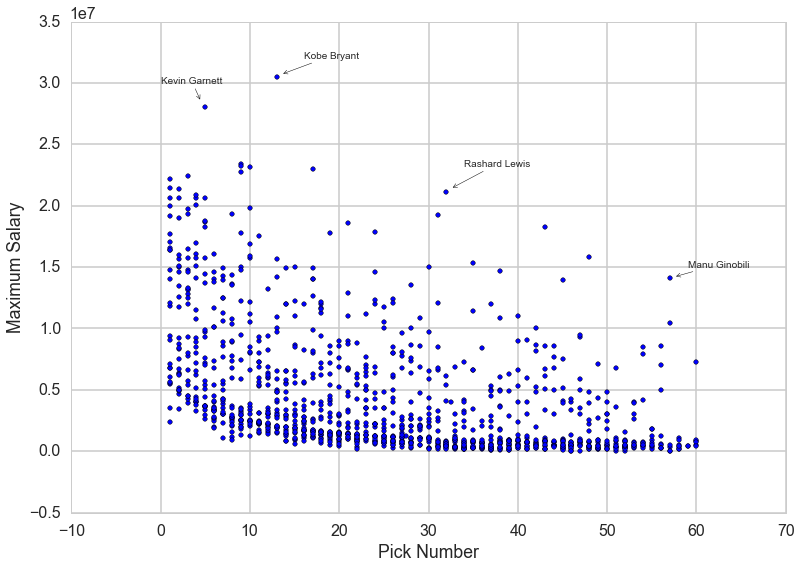

In [32]:
picks = []
maxsalary = []

#For each player, find their pick number (since each pick number is the same, the mean of their pick numbers will be
#that player's pick number) and the maximum salary achieved during his career
for player, group in players:
    picks.append(group['Pick'].mean())
    maxsalary.append(group['Salary'].max())
    
plt.scatter(picks, maxsalary);
plt.xlabel('Pick Number');
plt.ylabel('Maximum Salary');
plt.annotate('Kobe Bryant', xy = (13.5,30700000), xytext = (16, 32000000),
             arrowprops = dict(arrowstyle = '->'));
plt.annotate('Kevin Garnett', xy = (4.5, 28500000), xytext = (0, 30000000),
             arrowprops = dict(arrowstyle = '->'));
plt.annotate('Rashard Lewis', xy = (32.5, 21400000), xytext = (34, 23200000),
             arrowprops = dict(arrowstyle = '->'));
plt.annotate('Manu Ginobili', xy = (57.5, 14200000), xytext = (59, 15000000), 
             arrowprops = dict(arrowstyle = '->'));

We do begin to see a pattern where, in the earlier picks especially, there is an overall downward trend, suggesting that the best talent is actually chosen within the first 20 or so picks.  However, once we get past that, the graph looks incredibly noisy.  We've also labeled some prominent draft steals, players who seem to overperform their draft position significantly.  We can also find the drafted players with the highest and lowest max salary:

In [33]:
mergeddf[mergeddf['Salary'] == min(maxsalary)]

,NBA_Team,Old_Team,Pick,Player,Round,Year Drafted,2P,2P%,2PA,3P,3P%,3PA,AST,Age,BLK,DRB,FG,FG%,FGA,FT,FT%,FTA,G,GS,Lg,MP,ORB,PF,PTS,Player.1,Player.1_x,Player.1_y,Pos,STL,Salary,Season,TOV,TRB,Tm,eFG%
274,PHX,LSU,46,Ricky Blanton,2,1989,3,.429,7,0,NaN,0,1.0,26,0,1,3,.429,7,0,NaN,0,2,0,NBA,13,2,1,6,Ricky Blanton,NaN,NaN,SF,2.0,8000,1992-93,1,3.0,CHI,.429


In [34]:
mergeddf[mergeddf['Salary'] == max(maxsalary)]

,NBA_Team,Old_Team,Pick,Player,Round,Year Drafted,2P,2P%,2PA,3P,3P%,3PA,AST,Age,BLK,DRB,FG,FG%,FGA,FT,FT%,FTA,G,GS,Lg,MP,ORB,PF,PTS,Player.1,Player.1_x,Player.1_y,Pos,STL,Salary,Season,TOV,TRB,Tm,eFG%
2716,CHA,Lower Merion HS,13,Kobe Bryant,1,1996,28,0.491,57,3,.188,16,38,35,1,24,31,0.425,73,18,0.857,21,6,6,NBA,177,2,9,83,Kobe Bryant,Kobe Bryant,Kobe Bryant,SG,7,30453805,2013-14,34,26,LAL,0.445


And here's a list of all the players who have ever earned a maximum salary above $20 million.

In [35]:
richplayers = []

for player, group in players:
    if group['Salary'].max() > 20000000:
        richplayers.append(player)

print richplayers
len(richplayers)

['Alonzo Mourning', "Amar'e Stoudemire", 'Carmelo Anthony', 'Chris Bosh', 'Chris Paul', 'Dirk Nowitzki', 'Dwight Howard', 'Jason Kidd', "Jermaine O'Neal", 'Joe Johnson', 'Juwan Howard', 'Kevin Garnett', 'Kobe Bryant', 'LeBron James', 'Rashard Lewis', 'Stephon Marbury', 'Tim Duncan', 'Tracy McGrady']


18

Now, let's break down the histories of individual draft picks to see these draft steals and draft busts, defined as players who underperformed their pick number in terms of maximum salary.  Here, we plot a few graphs corresponding to some illustrative picks.

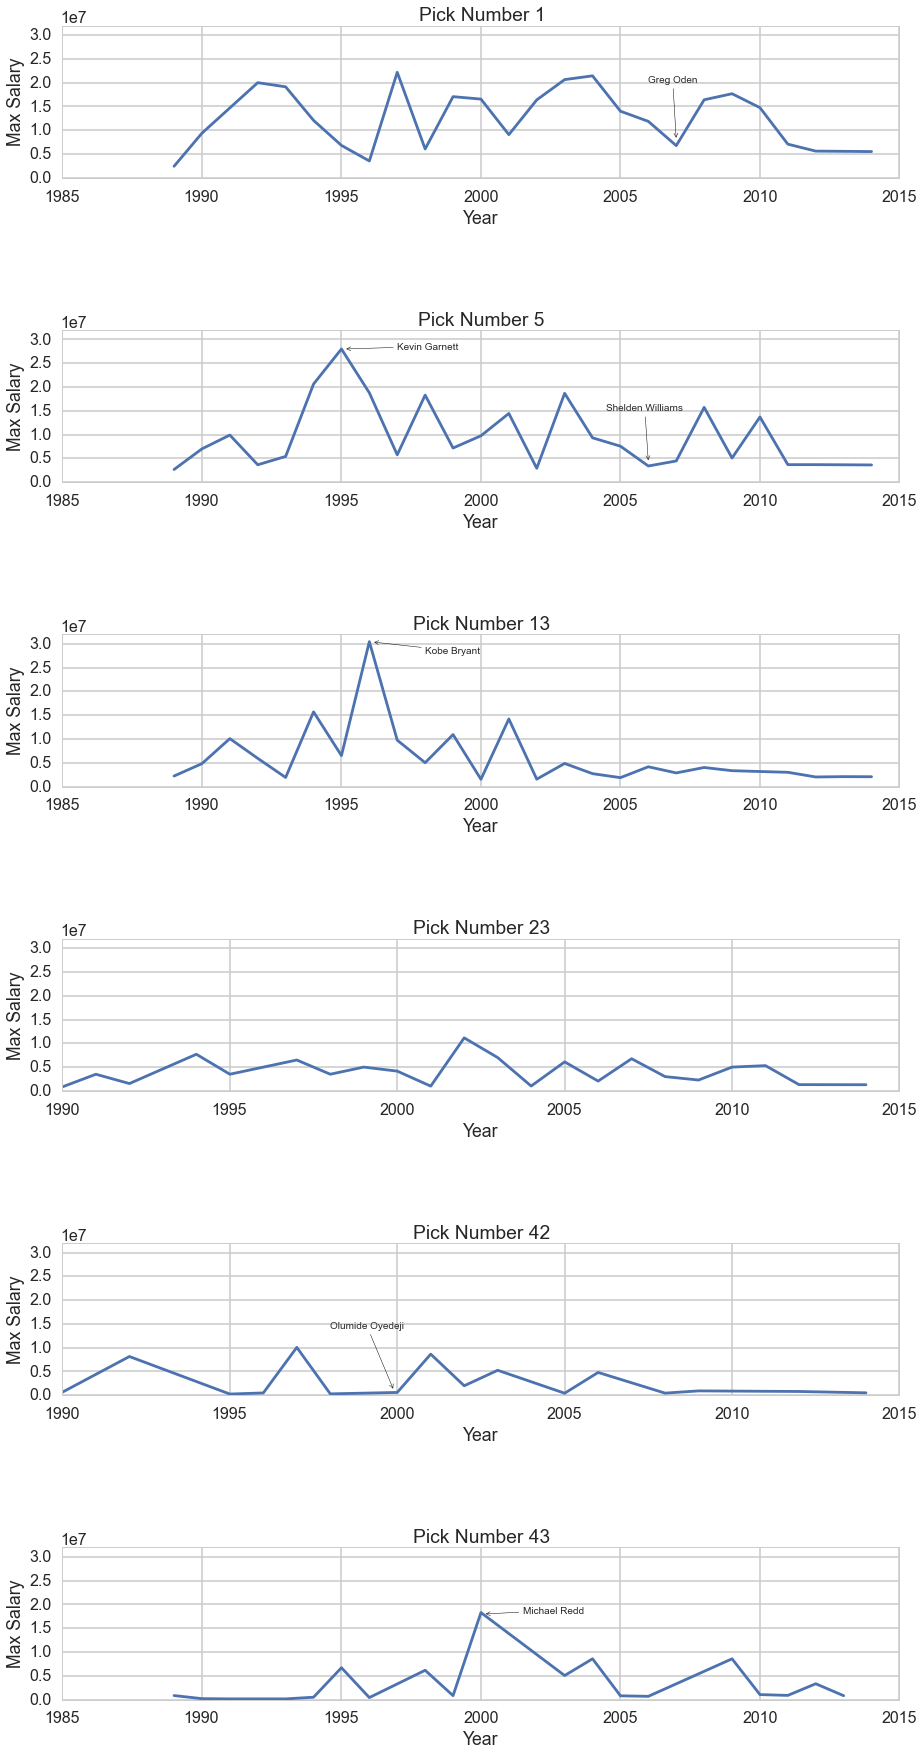

In [36]:
#Group our dataframe by pick number
picks = mergeddf.groupby('Pick')

#Make 6 plots, one for each interesting pick
fig, axes = plt.subplots(nrows = 6, ncols = 1, figsize = (15, 30))
plt.subplots_adjust(hspace = 1)
axeslist = axes.ravel()

#Define a list of picks which are illustrative
interestingpickslist = [1,5,13,23,42,43]
index = 0

maxsalaryperpick = {}
avgsalaryperpick = {}

for pick in range(1,61):
    
    #Get the information from this specific pick
    thispick = picks.get_group(pick)
    
    #For each year, find the maximum salary from that player
    thispickyears = thispick.groupby('Year Drafted')
    years = []
    maxsalaries = []
    avgsalaries = []
    for year, group in thispickyears:
        years.append(year)
        maxsalaries.append(group['Salary'].max())
        
    #Now plot the results if the pick is an interesting one
    if pick in interestingpickslist:
        
        ax = axeslist[index]
        ax.plot(years, maxsalaries);
        ax.set_xlabel('Year');
        ax.set_ylabel('Max Salary');
        ax.set_title('Pick Number %(number)i' % {'number' : pick});
        
        #Add annotations to identify some stieals and busts
        if pick == 1:
            ax.annotate('Greg Oden', xy = (2007, 8000000), xytext = (2006, 20000000),
                        arrowprops = dict(arrowstyle = '->'));
        elif pick == 5:
            ax.annotate('Shelden Williams', xy = (2006, 4200000), xytext = (2004.5, 15000000), 
                        arrowprops = dict(arrowstyle = '->'));
            ax.annotate('Kevin Garnett', xy = (1995.1, 28000000), xytext = (1997, 28000000),
                        arrowprops = dict(arrowstyle = '->'));
        elif pick == 13:
            ax.annotate('Kobe Bryant', xy = (1996.1, 30400000), xytext = (1998, 28000000),
                        arrowprops = dict(arrowstyle = '->'));
        elif pick == 42:
            ax.annotate('Olumide Oyedeji', xy = (1999.9, 1000000), xytext = (1998, 14000000),
                        arrowprops = dict(arrowstyle = '->'));
        elif pick == 43:
            ax.annotate('Michael Redd', xy = (2000.1, 18000000), xytext = (2001.5, 18200000),
                        arrowprops = dict(arrowstyle = '->'));
        ax.set_ylim([0, 32000000])
        index += 1
    
    #Add both the max salary at each pick and the average max salary at each pick (which represents the average value
    #of a player picked at that position) to dictionaries
    maxsalaryperpick[pick] = max(maxsalaries)
    avgsalaryperpick[pick] = np.mean(maxsalaries)

We can immediately see some conclusions: first, draft steals the likes of Kobe or Kevin Garnett are incredibly rare, but in the higher picks teams are more likely to pick players with higher maximum salaries, although busts are common.  Also, there are picks like the 23rd or the 42nd pick that have historically generated little value, even in years where there are players who would still offer more value later on.

We now plot the average salary and maximum salary for each pick in the draft.

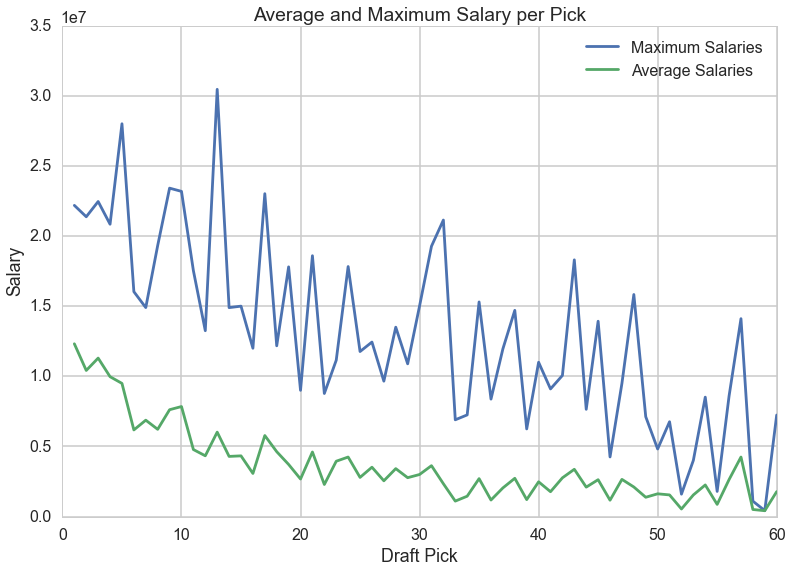

In [37]:
plt.plot(maxsalaryperpick.keys(), maxsalaryperpick.values(), label = 'Maximum Salaries');
plt.plot(avgsalaryperpick.keys(), avgsalaryperpick.values(), label = 'Average Salaries');
plt.title('Average and Maximum Salary per Pick');
plt.xlabel('Draft Pick');
plt.ylabel('Salary');
plt.legend(loc = 'upper right');

We do see an overall downward slope in both curves, suggesting that teams are actually successful at selecting higher value players earlier on in the draft.  But again, there is a lot of noise coming from players who are under or overvalued, so we'll try to figure out how to better evaluate these players.

Finally, let's look at individual teams to determine if any teams are better at picking players whose value is above the average value at their position.

In [38]:
teams = mergeddf.groupby('NBA_Team')

In [39]:
teamnames = []
teampercentaboveaverage = []

#Search by team
for team, group in teams:
    teamnames.append(team)
    
    #For each individual team, find all the players drafted by that team
    playersdraftedbyteam = group.groupby('Player')
    
    #If the player's maximum salary was better than the average maximum salary at his position,
    #increase the bettercounter
    bettercounter = 0.
    playercounter = 0.
    for player, secondgroup in playersdraftedbyteam:
        if secondgroup['Salary'].max() >= avgsalaryperpick[int(secondgroup['Pick'].mean())]:
            bettercounter += 1.
        playercounter += 1.
    
    #Give back the percentage of players for that team who were above average
    teampercentaboveaverage.append(bettercounter/playercounter)

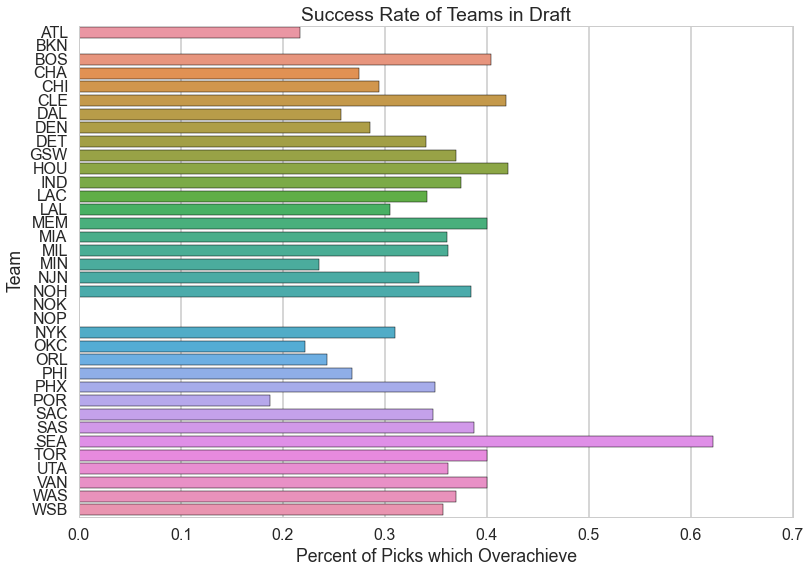

In [40]:
ax = sns.barplot(y=teamnames, x=teampercentaboveaverage);
ax.set_title('Success Rate of Teams in Draft');
ax.set_ylabel('Team');
ax.set_xlabel('Percent of Picks which Overachieve');

How do we interpret this graph?  Well, it makes sense that the majority of teams are actually below 50%, since a single draft steal can pull the average salary for his pick above the majority of players picked at that draft position.  That said, we can still draw the conclusion that the Boston Celtics, Cleveland Cavaliers, Golden State Warriors, and Seattle SuperSonics (by a longshot) tend to pick players who overperform their draft position.  This could be due to a better evaluation system or just luck of the draft position (for example, Cleveland was able to pick Lebron James, who would have overperformed whatever draft position he was chosen in, simply because they had the first overall pick).

In [41]:
mergeddf.to_csv('Data/NBADraftStats.csv', index=False)

# Regression on Draft Picks

College time!  Let's look at some college stats and see if we can do better than these teams.  Basketball-Reference has some college data, so we scraped for both current NBA players and retired NBA players to get a full dataframe of college stats.

In [42]:
collegeretireddf = pd.read_csv('Data/PastCollegeData.csv')
collegecurrentdf = pd.read_csv('Data/MergedCurCollege.csv')

#When scraping the dataframes, there were extra "unnamed" columns and extra "player" columns, so we just drop these
#so we can concatenate the dataframes with the same columns
collegeretireddf = collegeretireddf.drop(collegeretireddf.columns[[1]], axis = 1)
collegecurrentdf = collegecurrentdf.drop(collegecurrentdf.columns[[0]], axis = 1)

#Now make a merged dataframe
fullcollegedf = pd.concat([collegeretireddf,collegecurrentdf])
fullcollegedf.head()

,3P,3P%,3PA,AST,Age,BLK,College,FG,FG%,FGA,FT,FT%,FTA,G,MP,ORB,PF,PTS,Player,Player.1,STL,Season,TOV,TRB
0,NaN,NaN,NaN,0.2,18,3,DUKE,47,0.580,81,12,0.522,23,29,6.6,NaN,32,3.7,Alaa Abdelnaby,NaN,1,1986-87,13,1.7
1,NaN,NaN,NaN,0.1,19,3,DUKE,61,0.496,123,44,0.698,63,34,9.4,NaN,65,4.9,Alaa Abdelnaby,NaN,9,1987-88,33,2.0
2,NaN,NaN,NaN,0.3,20,16,DUKE,123,0.634,194,47,0.701,67,33,16.1,NaN,80,8.9,Alaa Abdelnaby,NaN,14,1988-89,40,3.8
3,NaN,NaN,NaN,0.7,21,48,DUKE,217,0.620,350,138,0.775,178,38,24.9,NaN,99,15.1,Alaa Abdelnaby,NaN,26,1989-90,54,6.6
4,NaN,NaN,NaN,NaN,18,NaN,UCLA,295,0.683,432,106,0.592,179,21,NaN,NaN,NaN,33.1,Kareem Abdul-Jabbar,NaN,NaN,1965-66,NaN,21.5


In [43]:
fullcollegedf.shape

(8635, 24)

We also drop the 'Player.1' column, which came about when merging the csv files.

In [44]:
fullcollegedf = fullcollegedf.drop('Player.1', axis = 1)
fullcollegedf.head()

,3P,3P%,3PA,AST,Age,BLK,College,FG,FG%,FGA,FT,FT%,FTA,G,MP,ORB,PF,PTS,Player,STL,Season,TOV,TRB
0,NaN,NaN,NaN,0.2,18,3,DUKE,47,0.580,81,12,0.522,23,29,6.6,NaN,32,3.7,Alaa Abdelnaby,1,1986-87,13,1.7
1,NaN,NaN,NaN,0.1,19,3,DUKE,61,0.496,123,44,0.698,63,34,9.4,NaN,65,4.9,Alaa Abdelnaby,9,1987-88,33,2.0
2,NaN,NaN,NaN,0.3,20,16,DUKE,123,0.634,194,47,0.701,67,33,16.1,NaN,80,8.9,Alaa Abdelnaby,14,1988-89,40,3.8
3,NaN,NaN,NaN,0.7,21,48,DUKE,217,0.620,350,138,0.775,178,38,24.9,NaN,99,15.1,Alaa Abdelnaby,26,1989-90,54,6.6
4,NaN,NaN,NaN,NaN,18,NaN,UCLA,295,0.683,432,106,0.592,179,21,NaN,NaN,NaN,33.1,Kareem Abdul-Jabbar,NaN,1965-66,NaN,21.5


In [45]:
fullcollegedf.shape

(8635, 23)

Now, we merge this dataframe of college statistics with the draft dataframe.  We left-merge so that we include players who were not drafted in this new dataframe, as we plan to run a regression to determine whether a player should be drafted.

In [46]:
mergedcollegedf = pd.merge(fullcollegedf, draftdf, how = 'left', on='Player')
mergedcollegedf.head()

,3P,3P%,3PA,AST,Age,BLK,College,FG,FG%,FGA,FT,FT%,FTA,G,MP,ORB,PF,PTS,Player,STL,Season,TOV,TRB,NBA_Team,Old_Team,Pick,Round,Year Drafted
0,NaN,NaN,NaN,0.2,18,3,DUKE,47,0.580,81,12,0.522,23,29,6.6,NaN,32,3.7,Alaa Abdelnaby,1,1986-87,13,1.7,POR,Duke,25,1,1990
1,NaN,NaN,NaN,0.1,19,3,DUKE,61,0.496,123,44,0.698,63,34,9.4,NaN,65,4.9,Alaa Abdelnaby,9,1987-88,33,2.0,POR,Duke,25,1,1990
2,NaN,NaN,NaN,0.3,20,16,DUKE,123,0.634,194,47,0.701,67,33,16.1,NaN,80,8.9,Alaa Abdelnaby,14,1988-89,40,3.8,POR,Duke,25,1,1990
3,NaN,NaN,NaN,0.7,21,48,DUKE,217,0.620,350,138,0.775,178,38,24.9,NaN,99,15.1,Alaa Abdelnaby,26,1989-90,54,6.6,POR,Duke,25,1,1990
4,NaN,NaN,NaN,NaN,18,NaN,UCLA,295,0.683,432,106,0.592,179,21,NaN,NaN,NaN,33.1,Kareem Abdul-Jabbar,NaN,1965-66,NaN,21.5,NaN,NaN,NaN,NaN,NaN


In [47]:
mergedcollegedf.shape

(8660, 28)

At this point, we need to clean our dataframe.  First, we need to get rid of some rows which have empty values in every entry - for some reason, Basketball-Reference didn't keep track of any reliable information for these players, so we just remove them from our dataframe.

In [48]:
bettercollegedf = mergedcollegedf[mergedcollegedf['Player'] != 'Quincy Acy']
bettercollegedf2 = bettercollegedf[bettercollegedf['Player'] != 'Renaldo Major']
bettercollegedf3 = bettercollegedf2[bettercollegedf2['Player'] != 'Kenny Williams']
bettercollegedf4 = bettercollegedf3[bettercollegedf3['Player'] != 'Harold Ellis']
mergedcollegedf = bettercollegedf4[bettercollegedf4['Player'] != 'Jonathan Kerner']

In [49]:
mergedcollegedf.shape

(8643, 28)

Now, we remove all data which corresponds to a year earlier than our draft information can handle - for example, Kareem-Abdul Jabbar is in our college dataframe, but he played college basketball in the 1960s, so we definitely don't have any information about whether he was drafted in the draft portion of the dataframe.

In [50]:
seasonmask = []

#For each entry in the Season column, check if the first four characters denote a year at or past 1988
for season in mergedcollegedf['Season'].values:
    seasonmask.append(int(season[:4]) >= 1988)

recentcollegedf = mergedcollegedf[seasonmask]

In [51]:
recentcollegedf.shape

(4801, 28)

In [52]:
recentcollegedf.head()

,3P,3P%,3PA,AST,Age,BLK,College,FG,FG%,FGA,FT,FT%,FTA,G,MP,ORB,PF,PTS,Player,STL,Season,TOV,TRB,NBA_Team,Old_Team,Pick,Round,Year Drafted
2,NaN,NaN,NaN,0.3,20,16,DUKE,123,0.634,194,47,0.701,67,33,16.1,NaN,80,8.9,Alaa Abdelnaby,14,1988-89,40,3.8,POR,Duke,25,1,1990
3,NaN,NaN,NaN,0.7,21,48,DUKE,217,0.620,350,138,0.775,178,38,24.9,NaN,99,15.1,Alaa Abdelnaby,26,1989-90,54,6.6,POR,Duke,25,1,1990
8,84,0.389,216,4.1,19,6,LSU,359,0.486,739,163,0.815,200,32,36.9,NaN,70,30.2,Mahmoud Abdul-Rauf,55,1988-89,113,3.4,NaN,NaN,NaN,NaN,NaN
9,88,0.358,246,3.2,20,1,LSU,305,0.461,662,191,0.910,210,32,37.6,NaN,66,27.8,Mahmoud Abdul-Rauf,52,1989-90,117,2.5,NaN,NaN,NaN,NaN,NaN
10,4,0.286,14,0.5,19,6,MICHIGAN,49,0.510,96,13,0.565,23,32,13.1,NaN,69,3.6,Tariq Abdul-Wahad,18,1993-94,30,2.3,SAC,San Jose State,11,1,1997


Another issue that we have is that some of these players have NaN values in columns relating to three-point shots.  In this case, we'll just set the values to 0 instead, as we assume those players just didn't take any three-point shots.  Since the three-point shot was only introduced to college basketball in 1986.

In [53]:
recentcollegedf.loc[np.isnan(recentcollegedf['3P']), ['3P']] = 0.
recentcollegedf.loc[np.isnan(recentcollegedf['3P%']), ['3P%']] = 0.
recentcollegedf.loc[np.isnan(recentcollegedf['3PA']), ['3PA']] = 0.

C:\Users\DBooth\Anaconda\lib\site-packages\pandas\core\indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [54]:
recentcollegedf.head()

,3P,3P%,3PA,AST,Age,BLK,College,FG,FG%,FGA,FT,FT%,FTA,G,MP,ORB,PF,PTS,Player,STL,Season,TOV,TRB,NBA_Team,Old_Team,Pick,Round,Year Drafted
2,0,0.000,0,0.3,20,16,DUKE,123,0.634,194,47,0.701,67,33,16.1,NaN,80,8.9,Alaa Abdelnaby,14,1988-89,40,3.8,POR,Duke,25,1,1990
3,0,0.000,0,0.7,21,48,DUKE,217,0.620,350,138,0.775,178,38,24.9,NaN,99,15.1,Alaa Abdelnaby,26,1989-90,54,6.6,POR,Duke,25,1,1990
8,84,0.389,216,4.1,19,6,LSU,359,0.486,739,163,0.815,200,32,36.9,NaN,70,30.2,Mahmoud Abdul-Rauf,55,1988-89,113,3.4,NaN,NaN,NaN,NaN,NaN
9,88,0.358,246,3.2,20,1,LSU,305,0.461,662,191,0.910,210,32,37.6,NaN,66,27.8,Mahmoud Abdul-Rauf,52,1989-90,117,2.5,NaN,NaN,NaN,NaN,NaN
10,4,0.286,14,0.5,19,6,MICHIGAN,49,0.510,96,13,0.565,23,32,13.1,NaN,69,3.6,Tariq Abdul-Wahad,18,1993-94,30,2.3,SAC,San Jose State,11,1,1997


In [55]:
recentcollegedf.shape

(4801, 28)

We then add a column to specify if a player was drafted, so that we can use it as a response for a classifier.

In [56]:
notdraftedlist = []

for pick in recentcollegedf['Pick'].values:
    notdraftedlist.append(pick != pick)

recentcollegedf['Drafted'] = [int(not x) for x in notdraftedlist]

C:\Users\DBooth\Anaconda\lib\site-packages\IPython\kernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [57]:
recentcollegedf.head()

,3P,3P%,3PA,AST,Age,BLK,College,FG,FG%,FGA,FT,FT%,FTA,G,MP,ORB,PF,PTS,Player,STL,Season,TOV,TRB,NBA_Team,Old_Team,Pick,Round,Year Drafted,Drafted
2,0,0.000,0,0.3,20,16,DUKE,123,0.634,194,47,0.701,67,33,16.1,NaN,80,8.9,Alaa Abdelnaby,14,1988-89,40,3.8,POR,Duke,25,1,1990,1
3,0,0.000,0,0.7,21,48,DUKE,217,0.620,350,138,0.775,178,38,24.9,NaN,99,15.1,Alaa Abdelnaby,26,1989-90,54,6.6,POR,Duke,25,1,1990,1
8,84,0.389,216,4.1,19,6,LSU,359,0.486,739,163,0.815,200,32,36.9,NaN,70,30.2,Mahmoud Abdul-Rauf,55,1988-89,113,3.4,NaN,NaN,NaN,NaN,NaN,0
9,88,0.358,246,3.2,20,1,LSU,305,0.461,662,191,0.910,210,32,37.6,NaN,66,27.8,Mahmoud Abdul-Rauf,52,1989-90,117,2.5,NaN,NaN,NaN,NaN,NaN,0
10,4,0.286,14,0.5,19,6,MICHIGAN,49,0.510,96,13,0.565,23,32,13.1,NaN,69,3.6,Tariq Abdul-Wahad,18,1993-94,30,2.3,SAC,San Jose State,11,1,1997,1


What percentage of players in this dataframe were drafted?

In [58]:
recentcollegedf['Drafted'].mean()

0.6721516350760258

At this point, we are forced to confront the inconsistency of our data.  The columns corresponding to minutes played, turnovers, blocks, steals, offensive rebounds, and personal fouls all have at least 600 entries which are NaN values, and removing all of those rows would significantly impact our analysis.  So, instead, we concede the point and remove those columns instead - we can't simply set the values to 0, since there are many records like the one below:

In [59]:
recentcollegedf[46:47]

,3P,3P%,3PA,AST,Age,BLK,College,FG,FG%,FGA,FT,FT%,FTA,G,MP,ORB,PF,PTS,Player,STL,Season,TOV,TRB,NBA_Team,Old_Team,Pick,Round,Year Drafted,Drafted
91,0,0,0,0.8,19,40,VILLANOVA,91,0.469,194,58,0.725,80,29,NaN,NaN,NaN,8.3,Malik Allen,19,1997-98,NaN,5.8,NaN,NaN,NaN,NaN,NaN,0


It's clear here that this player definitely played in a number of games, so his minutes played cannot just be 0.  We also can't just assume that he committed no fouls and made no turnovers, for example.  Thus, we just have to drop these columns.

In [60]:
recentcollegedf = recentcollegedf.drop(['ORB', 'BLK', 'PF', 'MP', 'TOV', 'STL'], axis = 1)

In [61]:
recentcollegedf.shape

(4801, 23)

In [62]:
recentcollegedf.head()

,3P,3P%,3PA,AST,Age,College,FG,FG%,FGA,FT,FT%,FTA,G,PTS,Player,Season,TRB,NBA_Team,Old_Team,Pick,Round,Year Drafted,Drafted
2,0,0.000,0,0.3,20,DUKE,123,0.634,194,47,0.701,67,33,8.9,Alaa Abdelnaby,1988-89,3.8,POR,Duke,25,1,1990,1
3,0,0.000,0,0.7,21,DUKE,217,0.620,350,138,0.775,178,38,15.1,Alaa Abdelnaby,1989-90,6.6,POR,Duke,25,1,1990,1
8,84,0.389,216,4.1,19,LSU,359,0.486,739,163,0.815,200,32,30.2,Mahmoud Abdul-Rauf,1988-89,3.4,NaN,NaN,NaN,NaN,NaN,0
9,88,0.358,246,3.2,20,LSU,305,0.461,662,191,0.910,210,32,27.8,Mahmoud Abdul-Rauf,1989-90,2.5,NaN,NaN,NaN,NaN,NaN,0
10,4,0.286,14,0.5,19,MICHIGAN,49,0.510,96,13,0.565,23,32,3.6,Tariq Abdul-Wahad,1993-94,2.3,SAC,San Jose State,11,1,1997,1


In [63]:
sum(recentcollegedf['AST'].isnull().values)

39

At this point, the only columns with NaN values are the Assist column, for which there are only 39 (which we see above), and the FG% and FT% column, only in cases where the player attempted zero field goals or free throws.  We can fix these pretty easily - just remove rows where the assists is NaN and convert the other NaN values in the percentage columns to 0's.

In [64]:
recentcollegedf = recentcollegedf[~recentcollegedf['AST'].isnull()]
recentcollegedf.shape

(4762, 23)

In [65]:
recentcollegedf['FT%'] = recentcollegedf['FT%'].apply(lambda x : 0. if np.isnan(x) else x)
recentcollegedf['FG%'] = recentcollegedf['FG%'].apply(lambda x : 0. if np.isnan(x) else x)

In [66]:
recentcollegedf.shape

(4762, 23)

In [67]:
recentcollegedf.head()

,3P,3P%,3PA,AST,Age,College,FG,FG%,FGA,FT,FT%,FTA,G,PTS,Player,Season,TRB,NBA_Team,Old_Team,Pick,Round,Year Drafted,Drafted
2,0,0.000,0,0.3,20,DUKE,123,0.634,194,47,0.701,67,33,8.9,Alaa Abdelnaby,1988-89,3.8,POR,Duke,25,1,1990,1
3,0,0.000,0,0.7,21,DUKE,217,0.620,350,138,0.775,178,38,15.1,Alaa Abdelnaby,1989-90,6.6,POR,Duke,25,1,1990,1
8,84,0.389,216,4.1,19,LSU,359,0.486,739,163,0.815,200,32,30.2,Mahmoud Abdul-Rauf,1988-89,3.4,NaN,NaN,NaN,NaN,NaN,0
9,88,0.358,246,3.2,20,LSU,305,0.461,662,191,0.910,210,32,27.8,Mahmoud Abdul-Rauf,1989-90,2.5,NaN,NaN,NaN,NaN,NaN,0
10,4,0.286,14,0.5,19,MICHIGAN,49,0.510,96,13,0.565,23,32,3.6,Tariq Abdul-Wahad,1993-94,2.3,SAC,San Jose State,11,1,1997,1


Finally, let's convert the Season column to a float, representing the year in which that season started.

In [68]:
recentcollegedf['Season'] = recentcollegedf['Season'].apply(lambda x : float(x[:4]))

In [69]:
recentcollegedf.head()

,3P,3P%,3PA,AST,Age,College,FG,FG%,FGA,FT,FT%,FTA,G,PTS,Player,Season,TRB,NBA_Team,Old_Team,Pick,Round,Year Drafted,Drafted
2,0,0.000,0,0.3,20,DUKE,123,0.634,194,47,0.701,67,33,8.9,Alaa Abdelnaby,1988,3.8,POR,Duke,25,1,1990,1
3,0,0.000,0,0.7,21,DUKE,217,0.620,350,138,0.775,178,38,15.1,Alaa Abdelnaby,1989,6.6,POR,Duke,25,1,1990,1
8,84,0.389,216,4.1,19,LSU,359,0.486,739,163,0.815,200,32,30.2,Mahmoud Abdul-Rauf,1988,3.4,NaN,NaN,NaN,NaN,NaN,0
9,88,0.358,246,3.2,20,LSU,305,0.461,662,191,0.910,210,32,27.8,Mahmoud Abdul-Rauf,1989,2.5,NaN,NaN,NaN,NaN,NaN,0
10,4,0.286,14,0.5,19,MICHIGAN,49,0.510,96,13,0.565,23,32,3.6,Tariq Abdul-Wahad,1993,2.3,SAC,San Jose State,11,1,1997,1


Our goal now is to use these statistics to predict whether a player will be drafted and by whom.  In order to do that, though, we need to collapse this dataframe into a new dataframe where each player has only one row, giving the average production that player had in college.  The first thing we need to do though is throw out seasons where the player didn't have much playing time (due to redshirting, injury, etc.).  We'll use the arbitrary cutoff of 5 games for this.

In [70]:
recentcollegedf = recentcollegedf[recentcollegedf['G'] >= 5]

In [71]:
recentcollegedf.shape

(4741, 23)

Finally, average the results by using the aggregate function in groupby.

In [335]:
players = recentcollegedf.groupby('Player')

In [336]:
byplayerdf = players.aggregate(np.mean)

In [337]:
byplayerdf.head()

,3P,3P%,3PA,AST,Age,FG,FG%,FGA,FT,FT%,FTA,G,PTS,Season,TRB,Pick,Round,Year Drafted,Drafted
Player,,,,,,,,,,,,,,,,,,,
A.J. Bramlett,0.000000,0.00000,0.500000,0.875,20.5,108.75,0.522250,207.000000,57.000000,0.50725,104.000000,31.75,8.650000,1996.5,6.400000,39,2,1999,1
A.J. English,61.500000,0.46150,133.500000,3.100,21.5,271.50,0.500000,544.500000,204.000000,0.80200,255.500000,30.00,26.950000,1988.5,4.550000,37,2,1990,1
A.J. Guyton,70.750000,0.41250,171.000000,3.125,19.5,186.75,0.454250,410.500000,80.750000,0.79025,102.250000,32.00,16.525000,1997.5,3.325000,32,2,2000,1
A.J. Price,52.666667,0.34800,144.333333,4.700,21.0,143.00,0.410667,346.333333,89.333333,0.71900,123.666667,33.00,12.866667,2007.0,3.333333,52,2,2009,1
Aaron Brooks,51.250000,0.36975,137.000000,4.000,20.5,125.00,0.416500,291.000000,76.500000,0.82400,91.750000,28.75,12.550000,2004.5,3.350000,26,1,2007,1


In [338]:
byplayerdf.to_csv('Data/CollegeDraft.csv')

Now, let's use a logistic regression to see whether we can predict whether a player should be drafted.

In [339]:
from sklearn.linear_model import LogisticRegression

We begin by creating a mask to split our data into training and testing data.  For this framework, we used the general setup from hw3.

In [340]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(byplayerdf.shape[0]), train_size=0.7)

In [341]:
mask=np.ones(byplayerdf.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [342]:
mask.sum()

1080

We define a list of the columns we think will be useful for the regression, being careful not to include columns which are highly correlated (for example, we include field goals made and field goal percentage, but not field goals attempted).

In [343]:
cols = ['3P', '3P%', 'AST', 'Age', 'FG', 'FG%', 'FT', 'FT%', 'G', 'PTS', 'Season', 'TRB']

In [344]:
Xmatrix = byplayerdf[cols].values
Yresp = byplayerdf['Drafted'].values

In [345]:
Xmatrix_train = Xmatrix[mask]
Xmatrix_test = Xmatrix[~mask]
Yresp_train = Yresp[mask]
Yresp_test = Yresp[~mask]

We now run our logistic regression classifier, using GridSearchCV to do cross-validation on the C parameter.  We again cite hw3 for the framework here.

In [346]:
from sklearn.grid_search import GridSearchCV

logreg = LogisticRegression(penalty = 'l1')
Cs = [.001, .01, .1, 1, 10, 100, 1000]
params = {"C" : Cs}
model = GridSearchCV(logreg, param_grid = params, cv = 5)
model.fit(Xmatrix_train, Yresp_train)
bestmodel = model.best_estimator_
print model.best_params_

{'C': 100}


In [347]:
training_accuracy = bestmodel.score(Xmatrix_train, Yresp_train)
test_accuracy = bestmodel.score(Xmatrix_test, Yresp_test)
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

Accuracy on training data: 0.74
Accuracy on test data:     0.74


How does this accuracy compare to other classifiers?  Well, consider how many players were actually drafted.

In [348]:
byplayerdf['Drafted'].mean()

0.7005832793259883

If we were to choose a classifier which assumed that everyone would be drafted (obviously impossible based on the setup of the draft), we would expect 70% accuracy.  Thus, our classifier is actually quantifiably useful, since it is giving us more accuracy than this basic classifier.

We now consider different probability thresholds to see if we can get even more accuracy.  The following function takes in our logistic model, a threshold probability, and our data, and gives back the accuracy of a model where the player is considered to be drafted if the model predicts his draft probability to be above the threshold t.

In [349]:
def probthreshold(model, t, xtest, ytest):
    
    probs = model.predict_proba(xtest)
    yesprobs = probs[:,1]
    ypred = (yesprobs > t)*1
    correct = 0.
    total = float(len(ytest))
    for a, b in zip(ytest, ypred):
        if a == b:
            correct += 1.

    return correct/total

Using this new threshold function, we can plot how the accuracy of our model changes at different probability thresholds and find the best threshold for accuracy.

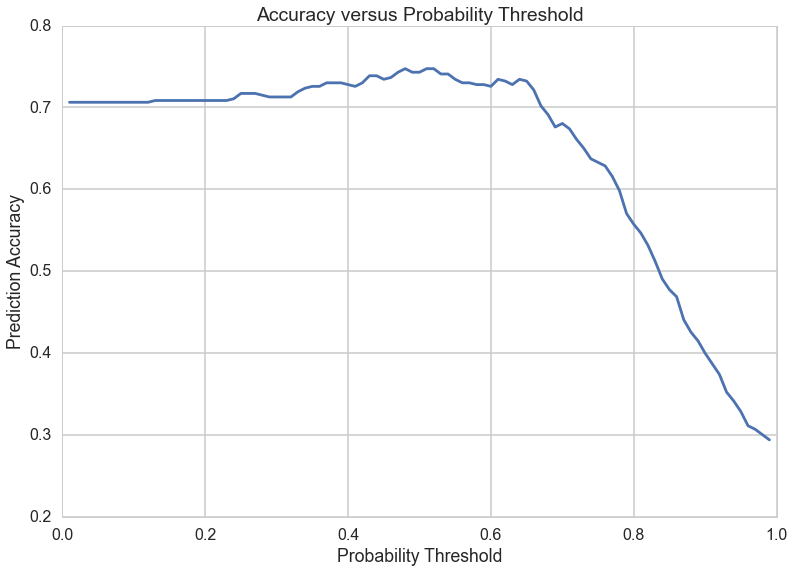

In [350]:
thresholds = np.arange(0.01, 1, 0.01)
ts = []
accuracies = []

for t in thresholds:
    ts.append(t)
    accuracies.append(probthreshold(bestmodel, t, Xmatrix_test, Yresp_test))

plt.plot(ts, accuracies);
plt.title('Accuracy versus Probability Threshold');
plt.xlabel('Probability Threshold');
plt.ylabel('Prediction Accuracy');

In [351]:
max(accuracies)

0.7473002159827213

We find that we can, in fact, improve our prediction accuracy by choosing a different probability threshold, although we can't get past 75% accuracy.  This makes sense, as we can't expect an incredibly high degree of accuracy here since there are differences in statistical performance over different eras which may not be included within the season parameter of the model.

Our second idea is to use a formula developed by the NBA to evaluate a player's efficiency.  The formula looks as follows:

$$EFF = (PTS + REB + AST + STL + BLK − Missed FG − Missed FT − TO) / GP$$

This formula is a precursor to the PER (Player Efficiency Rating) which is most often used in advanced stats discussions about the NBA, but that formula uses a lot of information about the general scoring climate of the rest of the league, as well as other leaguewide factors that we don't have access to here.  However, we can apply a modification of this efficiency formula (noting that we no longer have steal, block, or turnover data), make it a new column of this dataframe, and try to run the regression again.

Note that in this dataframe, the PTS and TRB columns are already listed in per-game form, so our efficiency formula will actually look like:

$$ourEFF = PTS + TRB + (AST - (FGA-FG) - (FTA-FT)) / GP$$

We will also continue to use games played, age, and season in our model, since they are not highly correlated with any of the above statistics.

To use this, we first have to add a column to represent a player's efficiency.

In [352]:
def oureff(row):
    return row['PTS'] + row['TRB'] + (row['AST'] - (row['FGA'] - row['FG']) - (row['FTA'] - row['FT']))/row['G']

In [353]:
efficiency = []

for index, row in byplayerdf.iterrows():
    efficiency.append(oureff(row))

In [354]:
byplayerdf['EFF'] = efficiency

In [355]:
byplayerdf.head()

,3P,3P%,3PA,AST,Age,FG,FG%,FGA,FT,FT%,FTA,G,PTS,Season,TRB,Pick,Round,Year Drafted,Drafted,EFF
Player,,,,,,,,,,,,,,,,,,,,
A.J. Bramlett,0.000000,0.00000,0.500000,0.875,20.5,108.75,0.522250,207.000000,57.000000,0.50725,104.000000,31.75,8.650000,1996.5,6.400000,39,2,1999,1,10.502756
A.J. English,61.500000,0.46150,133.500000,3.100,21.5,271.50,0.500000,544.500000,204.000000,0.80200,255.500000,30.00,26.950000,1988.5,4.550000,37,2,1990,1,20.786667
A.J. Guyton,70.750000,0.41250,171.000000,3.125,19.5,186.75,0.454250,410.500000,80.750000,0.79025,102.250000,32.00,16.525000,1997.5,3.325000,32,2,2000,1,12.283594
A.J. Price,52.666667,0.34800,144.333333,4.700,21.0,143.00,0.410667,346.333333,89.333333,0.71900,123.666667,33.00,12.866667,2007.0,3.333333,52,2,2009,1,9.140404
Aaron Brooks,51.250000,0.36975,137.000000,4.000,20.5,125.00,0.416500,291.000000,76.500000,0.82400,91.750000,28.75,12.550000,2004.5,3.350000,26,1,2007,1,9.734783


After doing this, we set up a new regression framework using the efficiency column and three other columns which are not highly correlated with the efficiency results, then make new training and test data using these columns.

In [356]:
effcols = ['Age', 'G', 'Season', 'EFF']

In [357]:
effXmatrix = byplayerdf[effcols].values

In [358]:
effXmatrix_train = effXmatrix[mask]
effXmatrix_test = effXmatrix[~mask]

Using this new efficiency calculation, we can instantiate another logistic regression model and compare its performance to the other logistic regression above.

In [359]:
efflogreg = LogisticRegression(penalty = 'l1')
Cs = [.001, .01, .1, 1, 10, 100, 1000]
params = {"C" : Cs}
effmodel = GridSearchCV(efflogreg, param_grid = params, cv = 5)
effmodel.fit(effXmatrix_train, Yresp_train)
effbestmodel = effmodel.best_estimator_
print effmodel.best_params_

{'C': 0.1}


In [360]:
efftraining_accuracy = effbestmodel.score(effXmatrix_train, Yresp_train)
efftest_accuracy = effbestmodel.score(effXmatrix_test, Yresp_test)
print "Accuracy on training data using efficiency: %0.2f" % (efftraining_accuracy)
print "Accuracy on test data using efficiency:     %0.2f" % (efftest_accuracy)

Accuracy on training data using efficiency: 0.72
Accuracy on test data using efficiency:     0.72


Once again, we make a threshold plot to find whether this efficiency data compares favorably to the other regression.

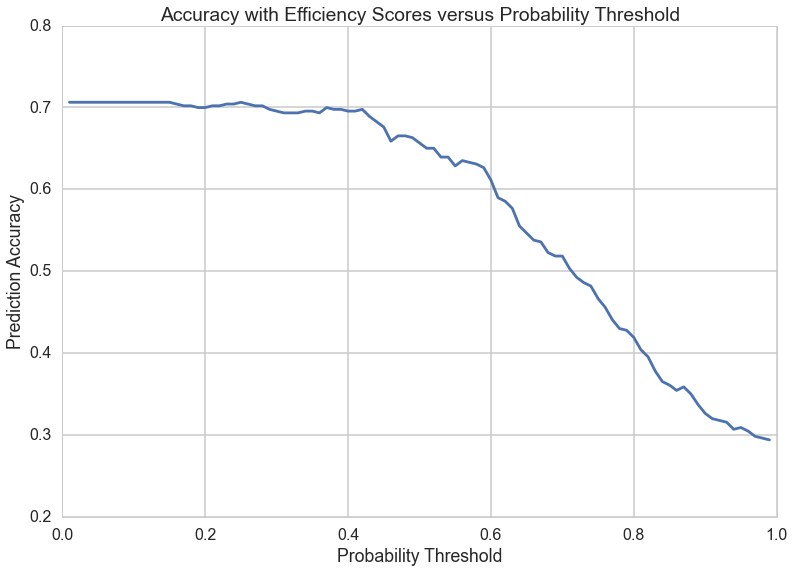

In [363]:
thresholds = np.arange(0.01, 1, 0.01)
ts = []
effaccuracies = []

for t in thresholds:
    ts.append(t)
    effaccuracies.append(probthreshold(newbestmodel, t, newXmatrix_test, Yresp_test))

plt.plot(ts, effaccuracies);
plt.title('Accuracy with Efficiency Scores versus Probability Threshold');
plt.xlabel('Probability Threshold');
plt.ylabel('Prediction Accuracy');

In [364]:
max(effaccuracies)

0.7062634989200864

The performance of this efficiency model is, albeit slightly worse than the original model, definitely comparable in accuracy and still better than the 70% baseline model of "everyone gets drafted".  We would expect that if the data for assists, steals, and the like were not corrupted, we could get an even better result here, but unfortunately we do not have access to any cleaner data.

Now that we know we can predict whether a player will be drafted with a pretty solid degree of accuracy, let's move on to try to predict the draft position of drafted players.  One way we can do this is flipping the Pick column to give higher ratings to players drafted highly and lower ratings for players drafted later in the draft, both so that better players will get higher "draft pick" scores and so that we can change the NaN values into zeros to allow for testing.  This does introduce some issues, in that it's hard to tell whether any player who was not drafted should be rated just one pick lower than the 60th pick, but we will try to address them later.

In [365]:
def recompute(pick):
    if np.isnan(pick):
        return 0.
    else:
        return 61.-pick

In [366]:
draftpos = byplayerdf['Pick'].apply(recompute).values

In [367]:
draftpos_train = draftpos[mask]
draftpos_test = draftpos[~mask]

After creating these new responses, we will try a few different types of regressions to determine how well we can predict draft position.  We start with a simple Ridge regression.

In [368]:
from sklearn.linear_model import Ridge

ridgereg = Ridge()
alphas = [.0001, .001, .01, .1, 1, 10, 100, 1000]
paramsnew = {'alpha' : alphas}
draftmodel = GridSearchCV(ridgereg, param_grid = paramsnew, cv = 5)
draftmodel.fit(Xmatrix_train, draftpos_train)
bestdraftmodel = draftmodel.best_estimator_
print draftmodel.best_params_

{'alpha': 1000}


In [369]:
print bestdraftmodel.score(Xmatrix_test, draftpos_test)

0.223635995389


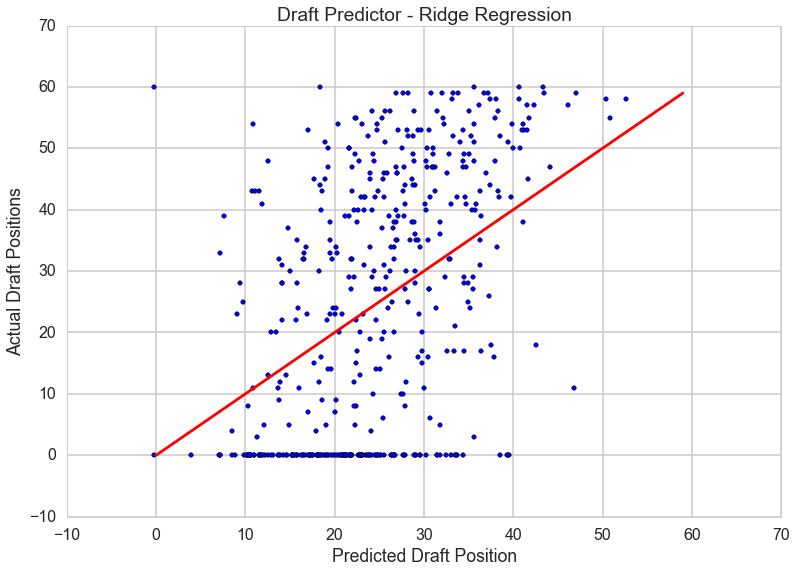

In [370]:
plt.scatter(bestdraftmodel.predict(Xmatrix_test), draftpos_test);
plt.plot(range(60), range(60), color = 'r');
plt.title('Draft Predictor - Ridge Regression');
plt.xlabel('Predicted Draft Position');
plt.ylabel('Actual Draft Positions');

Now let's try the same idea with a Lasso regression instead.

In [372]:
from sklearn.linear_model import Lasso

lassoreg = Lasso()
alphas = [.0001, .001, .01, .1, 1, 10, 100, 1000]
lassodraftmodel = GridSearchCV(lassoreg, param_grid = paramsnew, cv = 5)
lassodraftmodel.fit(Xmatrix_train, draftpos_train)
bestlassodraftmodel = lassodraftmodel.best_estimator_
print lassodraftmodel.best_params_

{'alpha': 1}


In [373]:
print bestlassodraftmodel.score(Xmatrix_test, draftpos_test)

0.229769340424


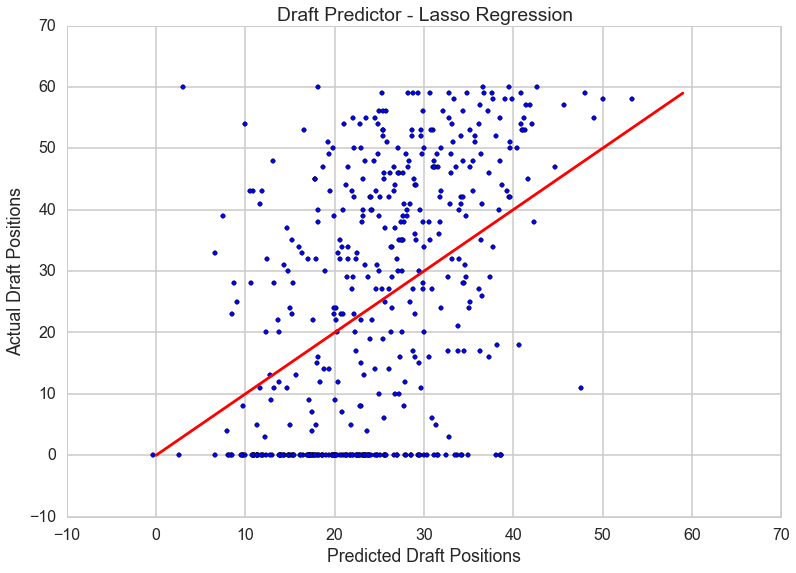

In [374]:
plt.scatter(bestlassodraftmodel.predict(Xmatrix_test), draftpos_test);
plt.plot(range(60), range(60), color = 'r');
plt.title('Draft Predictor - Lasso Regression');
plt.xlabel('Predicted Draft Positions');
plt.ylabel('Actual Draft Positions');

Let's try it now using the efficiency scores.

In [375]:
efflassoreg = Lasso()
efflassodraftmodel = GridSearchCV(efflassoreg, param_grid = paramsnew, cv = 5)
efflassodraftmodel.fit(effXmatrix_train, draftpos_train)
bestefflassodraftmodel = efflassodraftmodel.best_estimator_
print efflassodraftmodel.best_params_

{'alpha': 1}


In [376]:
print bestefflassodraftmodel.score(effXmatrix_test, draftpos_test)

0.233480216036


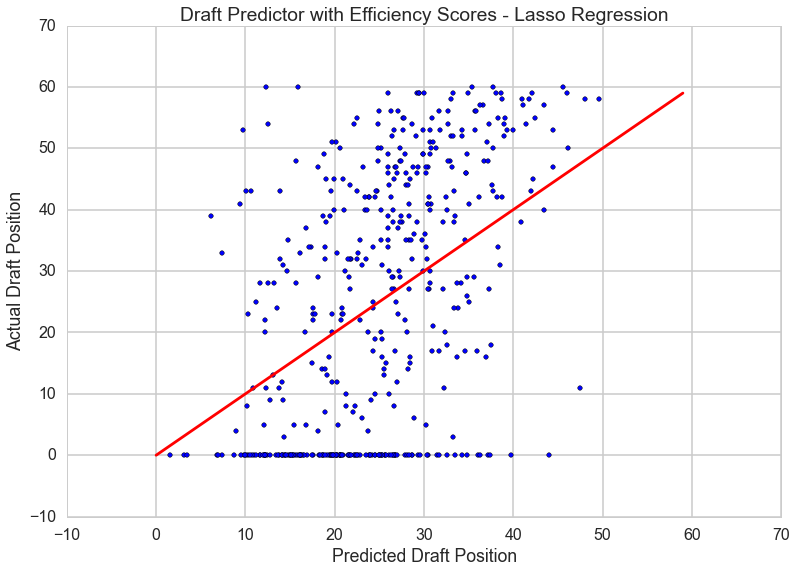

In [377]:
plt.scatter(bestefflassodraftmodel.predict(effXmatrix_test), draftpos_test);
plt.plot(range(60), range(60), color = 'r');
plt.title('Draft Predictor with Efficiency Scores - Lasso Regression');
plt.xlabel('Predicted Draft Position');
plt.ylabel('Actual Draft Position');

Here, the use of efficiency scores actually improves the accuracy of the prediction by a percentage point, but all three models have an R^2 value below 0.25.  We can see very clearly from the graphs that the large number of 0 values, which originally corresponded to the players which were not drafted, drags the R^2 value lower and lower, but the fit isn't that great without those values either.

To improve our results, let's try Random Forest.  For documentation, we cite: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [378]:
from sklearn import ensemble
#num_trees = [2,5,10,20,40,80,160,320,640,1000]
num_trees = [2,5,10,20,40,80,160,320,640]
max_features = [0.2,0.4,0.6,0.8,0.9,1]
maximum = 0
best_feature = 0
best_num_tree = 0
for tree in num_trees:
    for feature in max_features:
        clf = ensemble.RandomForestRegressor(n_estimators = tree,n_jobs = -1,warm_start = True,max_features=feature)
        clf.fit(Xmatrix_train, draftpos_train)
        r2 = clf.score(Xmatrix_test,draftpos_test)
        if r2 > maximum:
            best_num_tree = tree
            maximum = r2 
            best_feature = feature

print best_num_tree
print maximum
print best_feature

640
0.279659874955
0.4


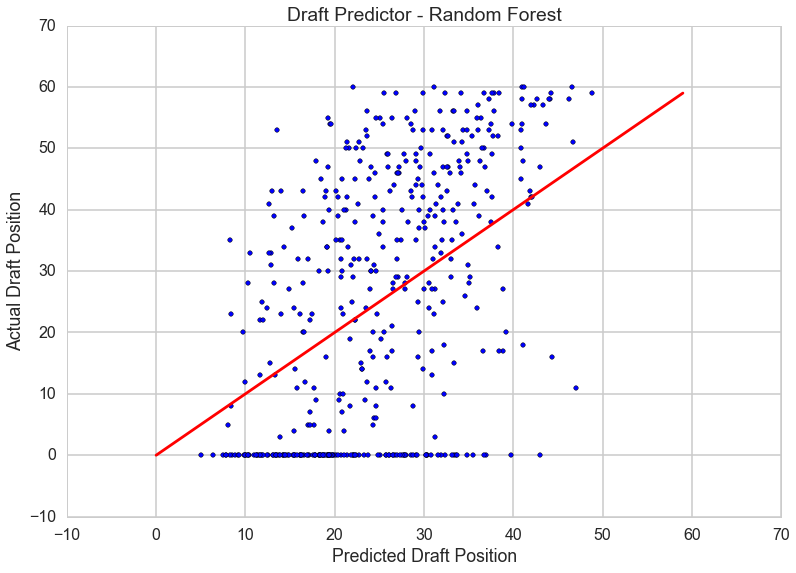

In [379]:
plt.scatter(clf.predict(Xmatrix_test), draftpos_test);
plt.plot(range(60), range(60), color = 'r');
plt.title('Draft Predictor - Random Forest');
plt.xlabel('Predicted Draft Position');
plt.ylabel('Actual Draft Position');

Now, we try using the efficiency scores within the Random Forest framework.

In [380]:
num_trees = [2,5,10,20,40,80,160,320,640]
max_features = [0.2,0.4,0.6,0.8,0.9,1]
maximum = 0
best_feature = 0
best_num_tree = 0
for tree in num_trees:
    for feature in max_features:
        effclf = ensemble.RandomForestRegressor(n_estimators = tree,n_jobs = -1,warm_start = True,max_features=feature)
        effclf.fit(effXmatrix_train, draftpos_train)
        r2 = effclf.score(effXmatrix_test,draftpos_test)
        if r2 > maximum:
            best_num_tree = tree
            maximum = r2 
            best_feature = feature

print best_num_tree
print maximum
print best_feature

160
0.24977936733
1


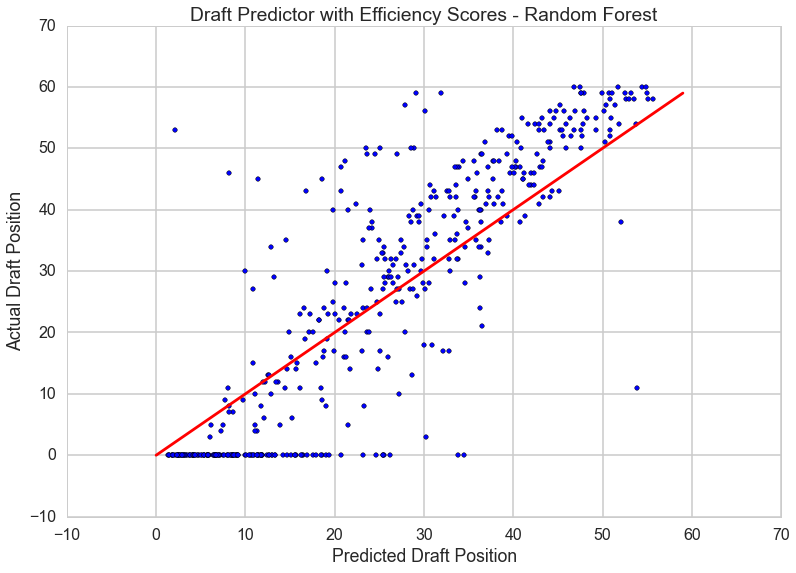

In [381]:
plt.scatter(clf2.predict(effXmatrix_test), draftpos_test);
plt.plot(range(60), range(60), color = 'r');
plt.title('Draft Predictor with Efficiency Scores - Random Forest');
plt.xlabel('Predicted Draft Position');
plt.ylabel('Actual Draft Position');

Using the Random Forest regressions, we see a noticeable increase in accuracy over the other models.  In fact, the efficiency score graph looks remarkably well correlated, ignoring the 0 values, even though the R^2 is only about 0.25.

Alternatively, we could actually throw out the players who were not drafted and attempt to predict draft position only on drafted players.  This does somewhat beg the question, as it basically makes the assumption that all these players will be drafted and then tries to figure out where they are drafted, but it is one other way we can analyze these results.  We will not recompute the picks here by flipping them, so a pick prediction of 1 will correspond to the first overall pick.

In [382]:
eliminateplayersdf = byplayerdf[byplayerdf['Drafted'] == 1]

In [383]:
eliminateplayersdf.head()

,3P,3P%,3PA,AST,Age,FG,FG%,FGA,FT,FT%,FTA,G,PTS,Season,TRB,Pick,Round,Year Drafted,Drafted,EFF
Player,,,,,,,,,,,,,,,,,,,,
A.J. Bramlett,0.000000,0.00000,0.500000,0.875,20.5,108.75,0.522250,207.000000,57.000000,0.50725,104.000000,31.75,8.650000,1996.5,6.400000,39,2,1999,1,10.502756
A.J. English,61.500000,0.46150,133.500000,3.100,21.5,271.50,0.500000,544.500000,204.000000,0.80200,255.500000,30.00,26.950000,1988.5,4.550000,37,2,1990,1,20.786667
A.J. Guyton,70.750000,0.41250,171.000000,3.125,19.5,186.75,0.454250,410.500000,80.750000,0.79025,102.250000,32.00,16.525000,1997.5,3.325000,32,2,2000,1,12.283594
A.J. Price,52.666667,0.34800,144.333333,4.700,21.0,143.00,0.410667,346.333333,89.333333,0.71900,123.666667,33.00,12.866667,2007.0,3.333333,52,2,2009,1,9.140404
Aaron Brooks,51.250000,0.36975,137.000000,4.000,20.5,125.00,0.416500,291.000000,76.500000,0.82400,91.750000,28.75,12.550000,2004.5,3.350000,26,1,2007,1,9.734783


In [384]:
eliminateplayersdf.shape

(1081, 20)

We need to create entirely new train-test splits on which we can re-run our regressions.

In [385]:
newitrain, newitest = train_test_split(xrange(eliminateplayersdf.shape[0]), train_size=0.7)

In [386]:
newmask=np.ones(eliminateplayersdf.shape[0], dtype='int')
newmask[newitrain]=1
newmask[newitest]=0
newmask = (newmask==1)

In [387]:
sum(newmask)

756

In [388]:
eliminatedXmatrix = eliminateplayersdf[cols].values
eliminatedeffXmatrix = eliminateplayersdf[effcols].values

eliminateddraftpos = eliminateplayersdf['Pick'].values

In [389]:
eliminatedXmatrix_train = eliminatedXmatrix[newmask]
eliminatedXmatrix_test = eliminatedXmatrix[~newmask]
eliminatedeffXmatrix_train = eliminatedeffXmatrix[newmask]
eliminatedeffXmatrix_test = eliminatedeffXmatrix[~newmask]

eliminateddraftpos_train = eliminateddraftpos[newmask]
eliminateddraftpos_test = eliminateddraftpos[~newmask]

With this new data, we attempt the same Lasso regression idea as above.

In [390]:
elimlassoreg = Lasso()
alphas = [.0001, .001, .01, .1, 1, 10, 100, 1000]
elimlassodraftmodel = GridSearchCV(elimlassoreg, param_grid = paramsnew, cv = 5)
elimlassodraftmodel.fit(eliminatedXmatrix_train, eliminateddraftpos_train)
bestelimlassodraftmodel = elimlassodraftmodel.best_estimator_
print elimlassodraftmodel.best_params_

{'alpha': 0.0001}


In [391]:
print bestelimlassodraftmodel.score(eliminatedXmatrix_test, eliminateddraftpos_test)

0.231106934082


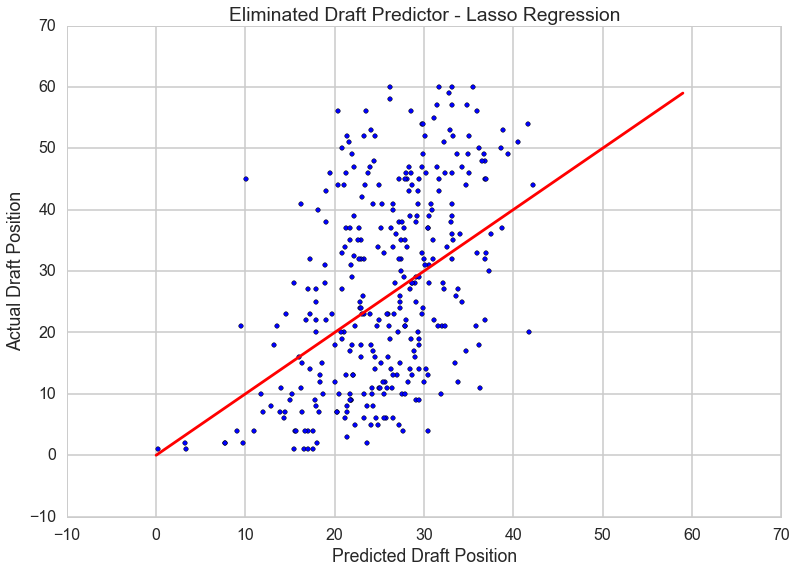

In [392]:
plt.scatter(bestelimlassodraftmodel.predict(eliminatedXmatrix_test), eliminateddraftpos_test);
plt.plot(range(60), range(60), color = 'r');
plt.title('Eliminated Draft Predictor - Lasso Regression');
plt.xlabel('Predicted Draft Position');
plt.ylabel('Actual Draft Position');

The R^2 value with the Lasso regression on this new eliminated dataset is almost exactly the same as the original lasso regressions, so this doesn't seem to be much of an improvement.  However, by observation we can see that the removal of the non-drafted players causes the model to shrink its predictions drastically, with the majority of data points landing in predicted draft positions between 10 and 40.  This makes sense, considering that if two players are going to be drafted, the stats of one player are likely going to be similar to that of the other, and the model may overcompensate for this similarity by shrinking the range of the majority of its predictions.

Let's run a Random Forest regression now on our new eliminated data.

In [393]:
num_trees = [2,5,10,20,40,80,160,320,640]
max_features = [0.2,0.4,0.6,0.8,0.9,1]
maximum = 0
best_feature = 0
best_num_tree = 0
for tree in num_trees:
    for feature in max_features:
        elimclf = ensemble.RandomForestRegressor(n_estimators = tree,n_jobs = -1,warm_start = True,max_features=feature)
        elimclf.fit(eliminatedXmatrix_train, eliminateddraftpos_train)
        r2 = elimclf.score(eliminatedXmatrix_test,eliminateddraftpos_test)
        if r2 > maximum:
            best_num_tree = tree
            maximum = r2 
            best_feature = feature

print best_num_tree
print maximum
print best_feature

80
0.197235259486
0.9


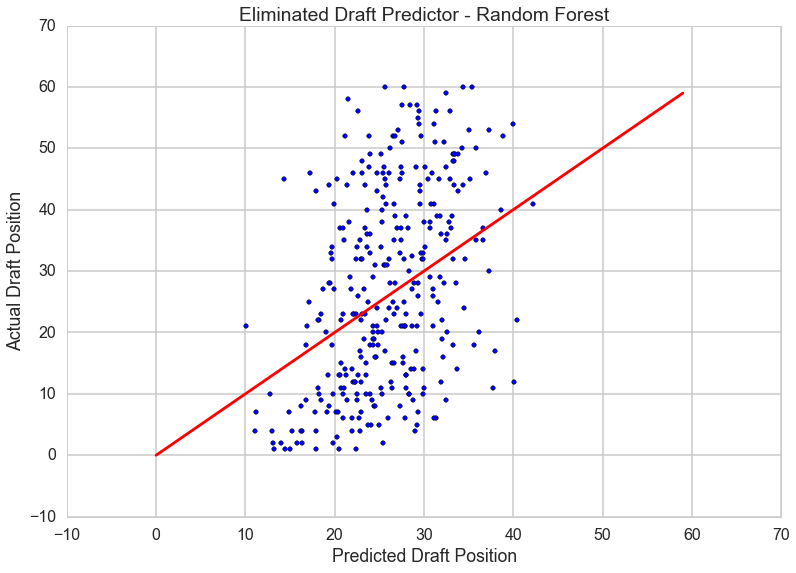

In [394]:
plt.scatter(elimclf.predict(eliminatedXmatrix_test), eliminateddraftpos_test);
plt.plot(range(60), range(60), color = 'r');
plt.title('Eliminated Draft Predictor - Random Forest');
plt.xlabel('Predicted Draft Position');
plt.ylabel('Actual Draft Position');

And, last but not least, we use our new eliminated data and efficiency scores in a Random Forest estimator.

In [395]:
num_trees = [2,5,10,20,40,80,160,320,640]
max_features = [0.2,0.4,0.6,0.8,0.9,1]
maximum = 0
best_feature = 0
best_num_tree = 0
for tree in num_trees:
    for feature in max_features:
        elimclf2 = ensemble.RandomForestRegressor(n_estimators = tree,n_jobs = -1,warm_start = True,max_features=feature)
        elimclf2.fit(eliminatedeffXmatrix_train, eliminateddraftpos_train)
        r2 = elimclf2.score(eliminatedeffXmatrix_test,eliminateddraftpos_test)
        if r2 > maximum:
            best_num_tree = tree
            maximum = r2 
            best_feature = feature

print best_num_tree
print maximum
print best_feature

320
0.164105091109
0.4


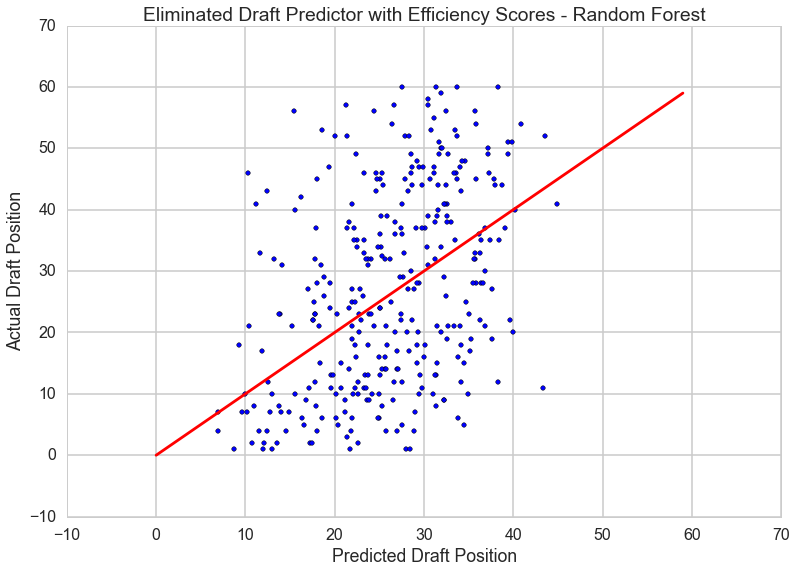

In [396]:
plt.scatter(elimclf2.predict(eliminatedeffXmatrix_test), eliminateddraftpos_test);
plt.plot(range(60), range(60), color = 'r');
plt.title('Eliminated Draft Predictor with Efficiency Scores - Random Forest');
plt.xlabel('Predicted Draft Position');
plt.ylabel('Actual Draft Position');

These random forest models on the eliminated dataset are remarkably poor, with R^2 values below .20.  We can again see that the prediction range has shrink, and the data does look poorly correlated.  This is again likely because the fact that these players definitely were drafted is a huge restriction on the type of college players that the model will see, which leads to poor predictive value.

For other possible directions in which this analysis could go, one idea would be to carry out a latent factors analysis.  Although this data does not seem particularly well suited for such a model, since it is a model chiefly for recommendations, and the act of drafting only one player means that each player only gets "recommended" by one team, so it would be difficult to determine similarity between players in that framework.  However, if it was applied, it would likely yield better results since certain teams may be predisposed to draft certain kinds of players.  For example, a team like the Golden State Warriors may be more likely to draft players with high 3P%, whereas a team like the Memphis Grizzlies may be likely to draft a player with more total rebounds and blocks.  This act of determining draft tendencies would likely inform the model and increase the accuracy by a significant amount.

Another improvement which could be made would be to adjust for the performance of the NBA team the year prior to that draft.  A team which has a losing record is possibly more likely to draft a higher-risk player, hoping for an immediate reward, so may go for more points scored.  However, a team that made the playoffs the year before may instead look for a player that they can develop, since they may not need immediate contributions, so they may be more likely to draft players with weaker overall stats based on the player's potential.